In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # 에러 메시지 확인

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from tqdm import tqdm
import numpy as np
import torchio as tio
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from collections import Counter
from scipy.ndimage import zoom, convolve1d
from models.lds_utils import get_lds_kernel_window
from models.loss import weighted_mse_loss
import gc
import types
import random
import torch
from torch import nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from sklearn.model_selection import train_test_split, KFold
from scipy.stats import pearsonr, spearmanr
import wandb
from develop_utils.send_message import send  # cell run 종료 시 카톡 메시지 전송

In [4]:
# models
from models.inception_resnet_v2 import inception_resnet_v2
from models.resnet import resnet26, resnet
from models.sfcn import SFCN
from models.vnet_encoder_reg import Regressor
from models.se_block import SEBlock

In [5]:
plt.rcParams['figure.figsize'] = 12, 6

In [6]:
RANDOM_SEED = 551

In [7]:
# control randomness
def set_seed(random_seed=551):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(random_seed)

In [8]:
def load_data(img_dir, label_dir, label_name):
    df = pd.read_csv(label_dir, index_col=0)[label_name]
    filenames = df.index
    images = []
    for index in tqdm(filenames):
        file_name = img_dir + index + '.npy'
        img = np.load(file_name)
        x, y, z = img.shape
        img = img.reshape((1, x, y, z))
        images.append(img)
    return images, df

In [9]:
def image_preprocess(img_size=192):
    # [16,32,48,64,80,96,112,128,144,160]
    sample_rate = 300 / img_size
    # transformation
    transform = tio.Compose([
        tio.Resample(sample_rate),
        tio.ZNormalization(),
    ])
    return transform

In [10]:
# augmentation
def get_augmentation_transform():
    random_rotate = tio.RandomAffine(scales=(1.0, 1.0),
                                     degrees=5,)
    random_flip = tio.RandomFlip(axes='LR',
                                 flip_probability=0.5)
    random_shift = tio.RandomAffine(scales=(1.0, 1.0),
                                    degrees=0,
                                    translation=(5,5,5))
    compose = tio.transforms.Compose([random_rotate, random_flip, random_shift])
    augment = tio.transforms.OneOf([random_rotate, random_flip, random_shift, compose])
    return augment

In [11]:
# ## Augmentation test
# def prepare_dataset(image_dir='./input_nifti_crop/', label_dir='./seg_nifti_crop/'):
#         # img_list = list(map(lambda path: img_dir + path, os.listdir(img_dir)))
#     filenames = os.listdir(label_dir)  # image_dir랑 label_dir에 저장되어있는 파일명이 같음

#     subjects = []
#     for filename in tqdm(filenames):
#         subject = tio.Subject(
#             img = tio.ScalarImage(image_dir + filename),
#             label = tio.LabelMap(label_dir + filename))   # label => LabelMap!!!!!!!
#         subjects.append(subject)
#     dataset = tio.SubjectsDataset(subjects)
#     return subjects, dataset

# image_dir = './input_nifti_300/'  #'./input_nifti/'
# label_dir = './seg_nifti_300/'  #'./input_nifti_seg/'
# subjects, dataset = prepare_dataset(image_dir, label_dir)

# random_rotate = tio.RandomAffine(scales=(1.0, 1.0),
#                                  degrees=5, p=1.0)
# random_shift = tio.RandomAffine(scales=(1.0, 1.0),
#                             degrees=0,
#                             translation=(5,5,5), p=1.0)

# print('without transform')
# dataset = tio.SubjectsDataset(subjects)
# for data in dataset:
#     img = data['img'].data[0,:,:,150]
#     plt.subplot(1,2,1)
#     plt.imshow(img, cmap='gray')
#     plt.axis('off')
    
#     img = np.max(data['img'].data[0,:,:,:].detach().numpy(), axis=1)
#     plt.subplot(1,2,2)
#     plt.imshow(img, cmap='gray')
#     plt.axis('off')
    
#     plt.show()
#     break

# print('with rotation')
# dataset = tio.SubjectsDataset(subjects, transform=random_rotate)
# for data in dataset:
#     img = data['img'].data[0,:,:,150]
#     plt.subplot(1,2,1)
#     plt.imshow(img, cmap='gray')
#     plt.axis('off')
    
#     img = np.max(data['img'].data[0,:,:,:].detach().numpy(), axis=1)
#     plt.subplot(1,2,2)
#     plt.imshow(img, cmap='gray')
#     plt.axis('off')
    
#     plt.show()
#     break
    
# print('with shift')
# dataset = tio.SubjectsDataset(subjects, transform=random_shift)
# for data in dataset:
#     img = data['img'].data[0,:,:,150]
#     plt.subplot(1,2,1)
#     plt.imshow(img, cmap='gray')
#     plt.axis('off')
    
#     img = np.max(data['img'].data[0,:,:,:].detach().numpy(), axis=1)
#     plt.subplot(1,2,2)
#     plt.imshow(img, cmap='gray')
#     plt.axis('off')
    
#     plt.show()
#     break

In [12]:
class NeckDataset(Dataset):
    def __init__(self, X=None, y=None, transform=None, lds=False, lds_kernel='gaussian', lds_ks=5, lds_sigma=2):
        self.X = X
        self.y = y.values
        self.transform = transform
        
        self.bin_edges = np.histogram_bin_edges(self.y, bins='auto')
        self.weights = self._prepare_weights(lds=lds, lds_kernel=lds_kernel, lds_ks=lds_ks, lds_sigma=lds_sigma)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        if self.transform is not None:
            image = self.transform(image)
        label = np.array([self.y[idx]]).astype('float16')
        weight = np.array([self.weights[idx]]).astype('float16') if self.weights is not None else np.asarray([np.float16(1.)])
        return [image, label, weight]
    
    def _prepare_weights(self, lds=False, lds_kernel='gaussian', lds_ks=5, lds_sigma=2):  
        weights = None
        if lds:
            labels = self.y
            bin_index_per_label = [self._get_bin_idx(label) for label in labels]
            Nb = max(bin_index_per_label) + 1
            num_samples_of_bins = dict(Counter(bin_index_per_label))
            emp_label_dist = [num_samples_of_bins.get(i, 0) for i in range(Nb)]

            lds_kernel_window = get_lds_kernel_window(kernel=lds_kernel, ks=lds_ks, sigma=lds_sigma)
            eff_label_dist = convolve1d(np.array(emp_label_dist), weights=lds_kernel_window, mode='constant')

            eff_num_per_label = [eff_label_dist[bin_idx] for bin_idx in bin_index_per_label]
            weights = np.array([np.float32(1 / x) for x in eff_num_per_label]).reshape(labels.shape)
        return weights
    
    def _get_bin_idx(self, label):
        return np.max(np.where(self.bin_edges <= label))

In [13]:
def train(model, train_loader, optimizer, epoch, lds=False, fds=False):
    total_loss_1, total_loss_2 = 0, 0
    preds, truths = np.array([]), np.array([])

    model.train()
    for inputs, labels, weights in tqdm(train_loader):
        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)
        weights = weights.to(device, dtype=torch.float)

        # feedforward
        if fds:
            outputs, _ = model(inputs, labels, epoch)
        else:
            outputs = model(inputs, labels, epoch)

        pred = outputs.detach().cpu().numpy()
        truth = labels.detach().cpu().numpy()
        preds = np.append(preds, pred.reshape(pred.size), axis=0)
        truths = np.append(truths, truth.reshape(truth.size), axis=0)

        # calculate loss
        if lds:
            loss1 = weighted_mse_loss(outputs, labels, weights=weights)
            loss2 = criterion2(outputs, labels)
        else:
            loss1 = criterion1(outputs, labels)
            loss2 = criterion2(outputs, labels)

        # gradient initialization
        optimizer.zero_grad()
        # backpropagation
        loss1.backward()
        # weight update
        optimizer.step()

        total_loss_1 += loss1.data.item()
        total_loss_2 += loss2.data.item()

        gc.collect()
        torch.cuda.empty_cache()

    if fds and epoch >= start_update:
        encodings, targets = [], []
        with torch.no_grad():
            for inputs, labels, _ in tqdm(train_loader):
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.float)
                outputs, feature = model(inputs, labels, epoch)
                encodings.extend(feature.data.squeeze().cpu().numpy())
                targets.extend(labels.data.squeeze().cpu().numpy())

        encodings, targets = torch.from_numpy(np.vstack(encodings)).cuda(), torch.from_numpy(np.hstack(targets)).cuda()
        if device_count > 1:
            model.module.FDS.update_last_epoch_stats(epoch)
            model.module.FDS.update_running_stats(encodings, targets, epoch)
        else:
            model.FDS.update_last_epoch_stats(epoch)
            model.FDS.update_running_stats(encodings, targets, epoch)

    return preds, truths, total_loss_1, total_loss_2

In [14]:
def valid(model, valid_loader):
    total_loss_1, total_loss_2 = 0, 0
    preds, truths = np.array([]), np.array([])

    model.eval()
    with torch.no_grad():
        for inputs, labels, _ in tqdm(valid_loader):
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)

            outputs = model(inputs)

            pred = outputs.detach().cpu().numpy()
            truth = labels.detach().cpu().numpy()
            preds = np.append(preds, pred.reshape(pred.size), axis=0)
            truths = np.append(truths, truth.reshape(truth.size), axis=0)

            loss1 = criterion1(outputs, labels)
            loss2 = criterion2(outputs, labels)

            total_loss_1 += loss1.data.item()
            total_loss_2 += loss2.data.item()

    return preds, truths, total_loss_1, total_loss_2

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
device_count = torch.cuda.device_count()
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 2


In [16]:
img_dir = './input_numpy_300/'  #'./input_nifti/'
label_dir = 'labels/data_975.csv'
label_name = 'FL_WMH_VOL_icv'

In [17]:
img_size = 192
batch_size = 4
test_batch_size = 4

In [17]:
# load data
X, y = load_data(img_dir, label_dir, label_name)

100%|█████████████████████████████████████████| 975/975 [07:36<00:00,  2.14it/s]


In [18]:
# initialize seed
set_seed()

# train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# image preprocessing
preprocess = image_preprocess()

# train set
train_set = NeckDataset(X_train, y_train, transform=preprocess, lds=True, lds_ks=100, lds_sigma=20)
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

# test set & loader
test_set = NeckDataset(X_test, y_test, transform=preprocess)
test_loader = DataLoader(test_set, batch_size=test_batch_size, num_workers=16)

len(X_train), len(X_test), len(y_train), len(y_test)

(780, 195, 780, 195)

In [19]:
dataset = NeckDataset(X, y, transform=preprocess)

In [20]:
# print('Dataset size : ', len(subjects), 'subjects')
print('Dataset size : ', len(y), 'subjects')
print('Training set:', len(train_set), 'subjects')
print('Validation set:', len(test_set), 'subjects')

Dataset size :  975 subjects
Training set: 780 subjects
Validation set: 195 subjects


In [21]:
y_max = y.max()
y_min = y.min()
y_max, y_min

(4.655252746039038, 0.0)

<AxesSubplot:>

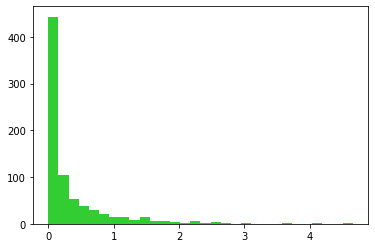

In [22]:
## 데이터셋 확인
y_train.hist(grid=False, bins=30, range=(y_min, y_max), color='limegreen')

<AxesSubplot:>

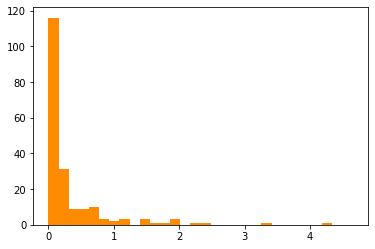

In [23]:
## 데이터셋 확인
y_test.hist(grid=False, bins=30, range=(y_min, y_max), color='darkorange')

(1, 192, 192, 192)
[1.478]
[0.001675]


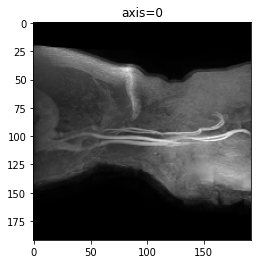

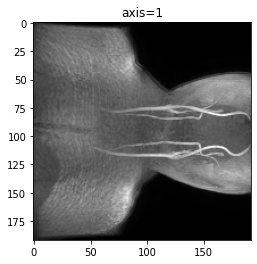

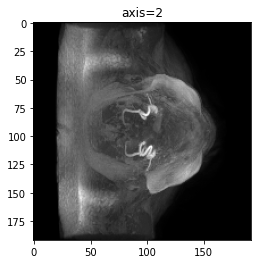

In [24]:
## 데이터셋 확인 (with LDS)
for img, label, weight in train_set:
    print(img.shape)
    print(label)
    print(weight)
    
    img = img.squeeze(0)
    
    plt.title("axis=0")
    plt.imshow(np.max(img, axis=0), cmap='gray')  # axis=0
    plt.show()
    
    plt.title("axis=1")
    plt.imshow(np.max(img, axis=1), cmap='gray')  # axis=1
    plt.show()
    
    plt.title("axis=2")
    plt.imshow(np.max(img, axis=2), cmap='gray')  # axis=2
    plt.show()
    break

In [161]:
## 데이터셋 확인 (with LDS)
label_list = []
weight_list = []
for _, label, weight in train_set:
    label_list.append(label[0])
    weight_list.append(weight[0])

<BarContainer object of 780 artists>

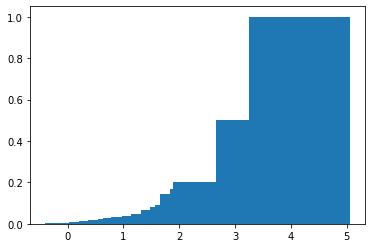

In [51]:
plt.bar(label_list, weight_list)  # lds with default value

<BarContainer object of 780 artists>

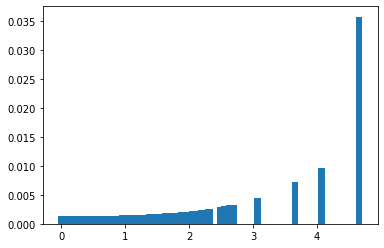

In [166]:
plt.bar(label_list, weight_list, width=0.1)  # lds with lds_ks=100, lds_sigma=20

In [32]:
label_dir = 'labels/data_975.csv'
label_name = 'FL_WMH_VOL_icv'
y = pd.read_csv(label_dir, index_col=0)[label_name]

lds_kernel='gaussian'
lds_ks=5  # default:5
lds_sigma=2  # default:2

def get_bin_idx(label):
    bin_edges = np.histogram_bin_edges(y, bins='auto')
    return np.max(np.where(bin_edges <= label))

labels = y.values
bin_index_per_label = [get_bin_idx(label) for label in labels]
Nb = max(bin_index_per_label) + 1
num_samples_of_bins = dict(Counter(bin_index_per_label))
emp_label_dist = [num_samples_of_bins.get(i, 0) for i in range(Nb)]

lds_kernel_window = get_lds_kernel_window(kernel=lds_kernel, ks=lds_ks, sigma=lds_sigma)
eff_label_dist = convolve1d(np.array(emp_label_dist), weights=lds_kernel_window, mode='constant')

eff_num_per_label = [eff_label_dist[bin_idx] for bin_idx in bin_index_per_label]

Text(0, 0.5, 'No. of subjects')

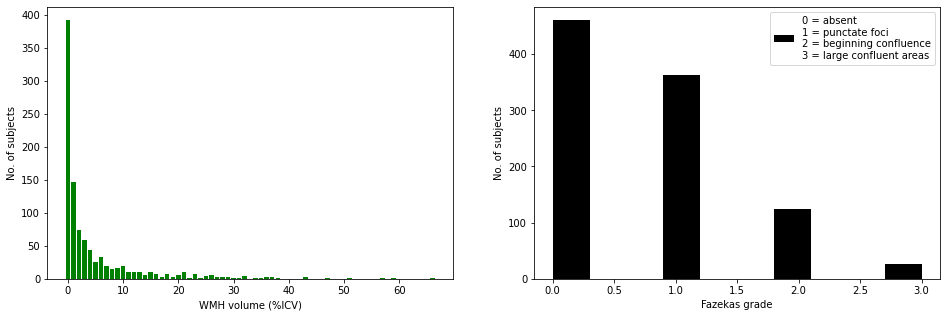

In [74]:
# empirical label distribution
x = np.arange(len(emp_label_dist))

plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
# plt.text(-1.5,400, 'A',
#    horizontalalignment='left',
#    verticalalignment='top',
#    bbox=dict(facecolor='white', alpha=0.6),
#    fontsize=12.5
plt.bar(x, emp_label_dist, color='green')
plt.ylabel('No. of subjects'); plt.xlabel('WMH volume (%ICV)')

plt.subplot(1,2,2)
df2 = pd.read_csv('labels/data_975.csv', index_col=0)['WMH_GRADE']
df2_label = '0 = absent\n1 = punctate foci\n2 = beginning confluence\n3 = large confluent areas'
df2.hist(grid=False, color='black', label=df2_label)
plt.legend()
plt.xlabel('Fazekas grade'); plt.ylabel('No. of subjects')

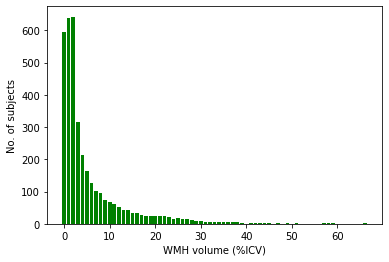

In [34]:
# effective label distribution
x = np.arange(len(eff_label_dist))
plt.bar(x, eff_label_dist, color='green')
plt.ylabel('No. of subjects'); plt.xlabel('WMH volume (%ICV)')
plt.show()

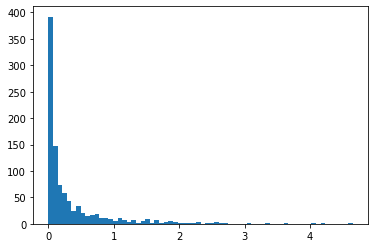

In [26]:
# Nb: number of bins
# n: list of number of data for each bin
# bins: list of data for each bin
plt.title('')
n, bins, _ = plt.hist(labels, bins=Nb-1)

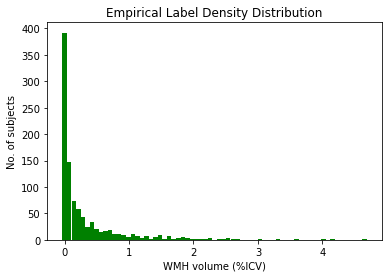

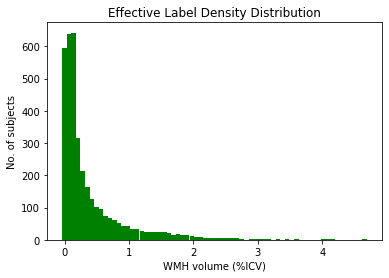

In [28]:
lds_kernel='gaussian'
lds_ks=5  # default:5
lds_sigma=2  # default:2

def get_bin_idx(label):
    bin_edges = np.histogram_bin_edges(y, bins='auto')
    return np.max(np.where(bin_edges <= label))

labels = y.values
bin_index_per_label = [get_bin_idx(label) for label in labels]
Nb = max(bin_index_per_label) + 1
num_samples_of_bins = dict(Counter(bin_index_per_label))
emp_label_dist = [num_samples_of_bins.get(i, 0) for i in range(Nb)]

lds_kernel_window = get_lds_kernel_window(kernel=lds_kernel, ks=lds_ks, sigma=lds_sigma)
eff_label_dist = convolve1d(np.array(emp_label_dist), weights=lds_kernel_window, mode='constant')

eff_num_per_label = [eff_label_dist[bin_idx] for bin_idx in bin_index_per_label]

plt.title('Empirical Label Density Distribution')
plt.bar(bins, emp_label_dist, width=0.07, color='green')
plt.ylabel('No. of subjects'); plt.xlabel('WMH volume (%ICV)')
plt.show()

plt.title('Effective Label Density Distribution')
plt.bar(bins, eff_label_dist, width=0.07, color='green')
plt.ylabel('No. of subjects'); plt.xlabel('WMH volume (%ICV)')
plt.show()

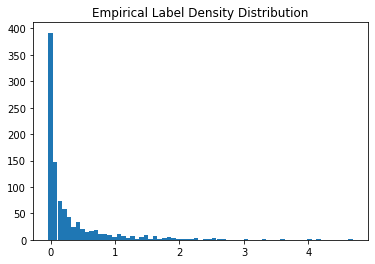

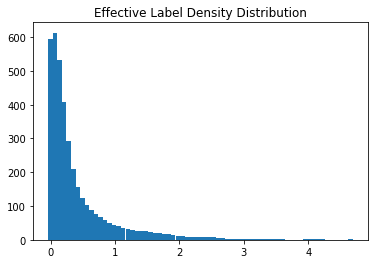

In [140]:
lds_kernel='gaussian'
lds_ks=100  # default:5
lds_sigma=2  # default:2

def get_bin_idx(label):
    bin_edges = np.histogram_bin_edges(y, bins='auto')
    return np.max(np.where(bin_edges <= label))

labels = y.values
bin_index_per_label = [get_bin_idx(label) for label in labels]
Nb = max(bin_index_per_label) + 1
num_samples_of_bins = dict(Counter(bin_index_per_label))
emp_label_dist = [num_samples_of_bins.get(i, 0) for i in range(Nb)]

lds_kernel_window = get_lds_kernel_window(kernel=lds_kernel, ks=lds_ks, sigma=lds_sigma)
eff_label_dist = convolve1d(np.array(emp_label_dist), weights=lds_kernel_window, mode='constant')

eff_num_per_label = [eff_label_dist[bin_idx] for bin_idx in bin_index_per_label]

plt.title('Empirical Label Density Distribution')
plt.bar(bins, emp_label_dist, width=0.07)
plt.show()

plt.title('Effective Label Density Distribution')
plt.bar(bins, eff_label_dist, width=0.07)
plt.show()

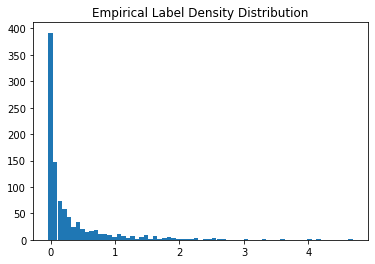

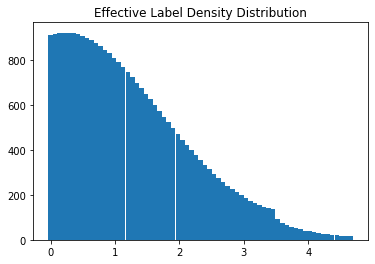

In [150]:
lds_kernel='gaussian'
lds_ks=100  # default:5
lds_sigma=20  # default:2

def get_bin_idx(label):
    bin_edges = np.histogram_bin_edges(y, bins='auto')
    return np.max(np.where(bin_edges <= label))

labels = y.values
bin_index_per_label = [get_bin_idx(label) for label in labels]
Nb = max(bin_index_per_label) + 1
num_samples_of_bins = dict(Counter(bin_index_per_label))
emp_label_dist = [num_samples_of_bins.get(i, 0) for i in range(Nb)]

lds_kernel_window = get_lds_kernel_window(kernel=lds_kernel, ks=lds_ks, sigma=lds_sigma)
eff_label_dist = convolve1d(np.array(emp_label_dist), weights=lds_kernel_window, mode='constant')

eff_num_per_label = [eff_label_dist[bin_idx] for bin_idx in bin_index_per_label]

plt.title('Empirical Label Density Distribution')
plt.bar(bins, emp_label_dist, width=0.07)
plt.show()

plt.title('Effective Label Density Distribution')
plt.bar(bins, eff_label_dist, width=0.07)
plt.show()

TO-DO

- [x] V-Net-1, 5-fold CV
- [x] V-Net-2, 5-fold CV
- [x] V-Net-3, 5-fold CV
- [x] V-Net-4, 5-fold CV
- [x] SFCN, 5-fold CV
- [x] ResNet10, 5-fold CV
- [x] ResNet18, 5-fold CV
- [x] ResNet26, 5-fold CV
- [x] Inception-ResNet-v2, 5-fold CV
- [x] V-Net-1
- [x] V-Net-2
- [x] V-Net-3
- [x] V-Net-4
- [x] SFCN
- [x] ResNet10
- [x] ResNet18
- [x] ResNet26
- [x] Inception-ResNet-v2
- [x] V-Net-1 + LDS
- [x] V-Net-1 + FDS
- [x] V-Net-1 + LDS + FDS
- [x] V-Net-1 + Ranking Loss

In [167]:
num_epochs = 100
weight_decay = 0.01
lr = 1e-06

In [168]:
from models.vnet_encoder_reg import Regressor

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hei-jung. Use `wandb login --relogin` to force relogin


# EPOCH 1 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 2 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.56it/s]


# EPOCH 3 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.57it/s]


# EPOCH 4 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


# EPOCH 5 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


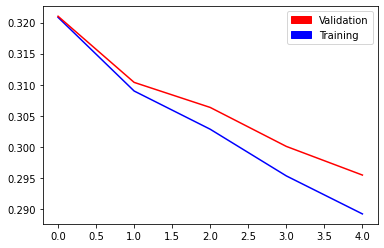

# EPOCH 6 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]


# EPOCH 7 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.57it/s]


# EPOCH 8 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


# EPOCH 9 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.63it/s]


# EPOCH 10 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.57it/s]


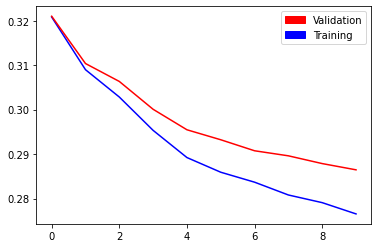

# EPOCH 11 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.55it/s]


# EPOCH 12 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.57it/s]


# EPOCH 13 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.57it/s]


# EPOCH 14 / 100


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 15 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.57it/s]


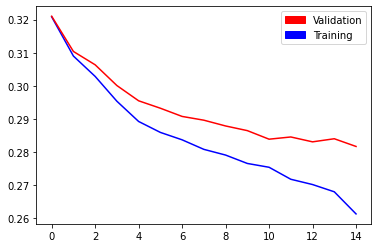

# EPOCH 16 / 100


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.69it/s]


# EPOCH 17 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 18 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]


# EPOCH 19 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 20 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


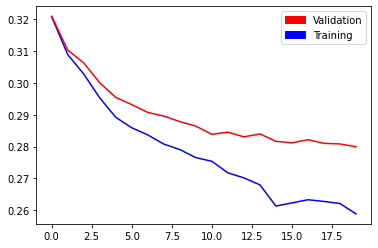

# EPOCH 21 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


# EPOCH 22 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 23 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


# EPOCH 24 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


# EPOCH 25 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.58it/s]


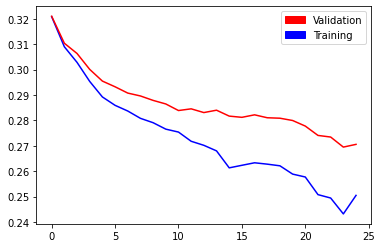

# EPOCH 26 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.58it/s]


# EPOCH 27 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.56it/s]


# EPOCH 28 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]


# EPOCH 29 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


# EPOCH 30 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


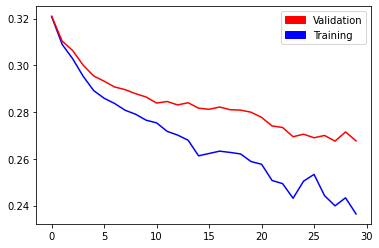

# EPOCH 31 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.63it/s]


# EPOCH 32 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.58it/s]


# EPOCH 33 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.60it/s]


# EPOCH 34 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]


# EPOCH 35 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.58it/s]


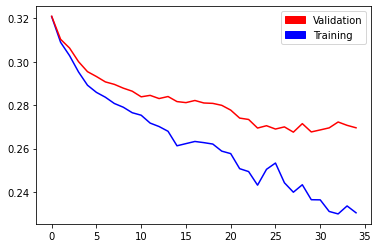

# EPOCH 36 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


# EPOCH 37 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


# EPOCH 38 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.57it/s]


# EPOCH 39 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.59it/s]


# EPOCH 40 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.57it/s]


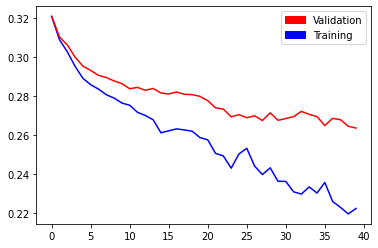

# EPOCH 41 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


# EPOCH 42 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


# EPOCH 43 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.55it/s]


# EPOCH 44 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]


# EPOCH 45 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


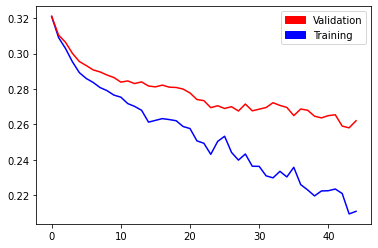

# EPOCH 46 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


# EPOCH 47 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.60it/s]


# EPOCH 48 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.58it/s]


# EPOCH 49 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.60it/s]


# EPOCH 50 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


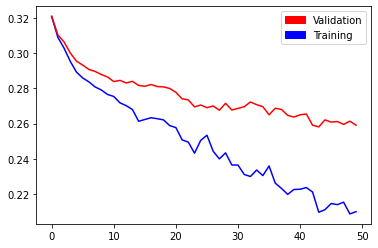

# EPOCH 51 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s]


# EPOCH 52 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.58it/s]


# EPOCH 53 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.56it/s]


# EPOCH 54 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s]


# EPOCH 55 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.55it/s]


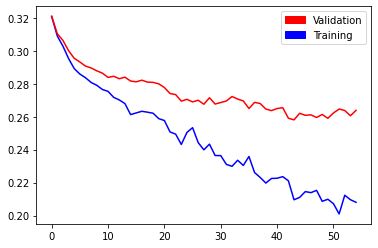

# EPOCH 56 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.56it/s]


# EPOCH 57 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.58it/s]


# EPOCH 58 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.58it/s]


# EPOCH 59 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


# EPOCH 60 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.57it/s]


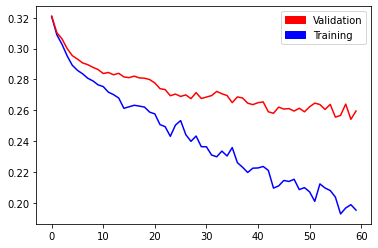

# EPOCH 61 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 62 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


# EPOCH 63 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 64 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


# EPOCH 65 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


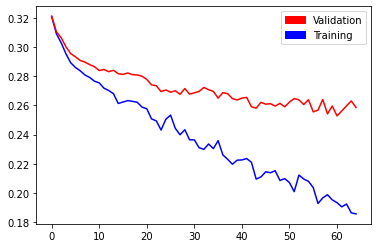

# EPOCH 66 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 67 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s]


# EPOCH 68 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.60it/s]


# EPOCH 69 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.60it/s]


# EPOCH 70 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


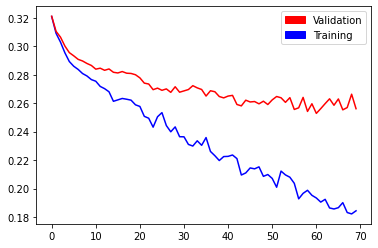

# EPOCH 71 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.56it/s]


# EPOCH 72 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]


# EPOCH 73 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 74 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]


# EPOCH 75 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


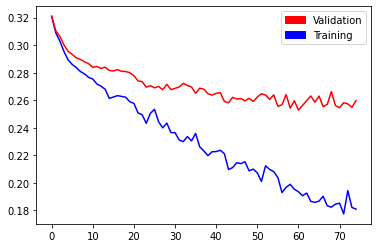

# EPOCH 76 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.63it/s]


# EPOCH 77 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.59it/s]


# EPOCH 78 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s]


# EPOCH 79 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


# EPOCH 80 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


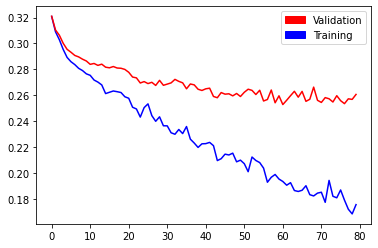

# EPOCH 81 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


# EPOCH 82 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.56it/s]


# EPOCH 83 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.55it/s]


# EPOCH 84 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.57it/s]


# EPOCH 85 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.60it/s]


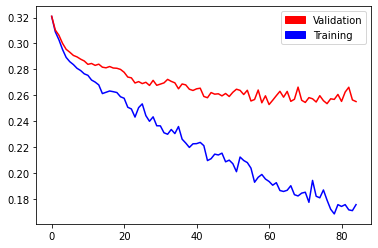

# EPOCH 86 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


# EPOCH 87 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


# EPOCH 88 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


# EPOCH 89 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.59it/s]


# EPOCH 90 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


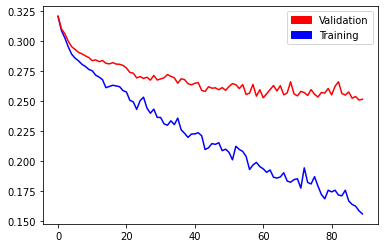

# EPOCH 91 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


# EPOCH 92 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.59it/s]


# EPOCH 93 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s]


# EPOCH 94 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.57it/s]


# EPOCH 95 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


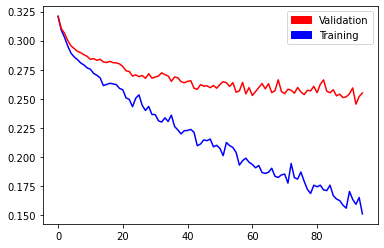

# EPOCH 96 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]


# EPOCH 97 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


# EPOCH 98 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


# EPOCH 99 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.57it/s]


# EPOCH 100 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


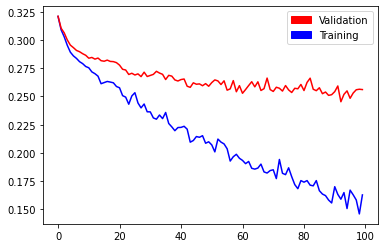

train_mae,█▇▆▆▆▅▅▅▅▄▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
train_mse,█▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁
train_pearson,▁▄▄▄▅▅▅▅▅▆▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇█████████
train_spearman,▁▃▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██▇██████████
valid_mae,█▇▅▅▄▅▅▅▅▄▄▃▃▄▂▃▄▂▃▃▃▂▂▂▂▄▂▃▃▂▂▁▄▃▃▂▃▃▁▂
valid_mse,█▇▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▂▁▃▂▁▁▂▂▂▁▁▂▁▁▂
valid_pearson,▁▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███▇█▇███▇████████
valid_spearman,▁▃▄▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇████▇███████
train_mae,0.25377
train_mse,0.16289
train_pearson,0.70432


In [35]:
# V-Net-1
normalization = 'groupnorm'
blocknum = 1
avg_pool = 3
dropout_rate = 0.
optim_class = optim.AdamW
lds = False
fds = True
start_update = 0

weight_filename = 'pretrained/230527_vnet-{}'.format(blocknum)
if lds:
    weight_filename += '+lds'
if fds:
    weight_filename += '+fds'

### VNet pretrained model 가져오기
set_seed()

out_size = 2 ** blocknum
out_size = 192 // out_size
out_size = out_size // avg_pool
num_fc = [out_size * out_size * out_size,30,16,4]
net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                fc_features=[*num_fc], dropout_p=dropout_rate, fds=fds)
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/seg_2304_vnetencoder-{}_{}_bestmodel'.format(blocknum, img_size)), strict=False)
net.cuda()

### Parameter freeze X
#     for i, [name, param] in enumerate(net.named_parameters()):
#         if 'encoder' in name:
#             param.requires_grad = False

### W&B 설정
wandb.init(
    project='202305-WMHvolPredRunAll',
    config={"model": "VNet-{}".format(blocknum),
            "lr": lr, "epochs": num_epochs, "batch_size": batch_size,
            "cost_function": "mse", "optimizer": optim_class.__name__, "weight_decay": weight_decay,
            "dropout": dropout_rate,
            "fds": fds, "lds": lds},
    notes='train with %d data'%(len(train_set)))
wandb.watch(net)

### 학습 시작
train_losses = []
validation_losses = []
min_valid_loss = 1.0

optimizer = optim_class(net.parameters(), lr=lr, weight_decay=weight_decay)
criterion1 = nn.MSELoss()
criterion2 = nn.L1Loss()

set_seed()
for epoch in range(num_epochs):
    # train set
    augment = get_augmentation_transform()
    train_set.transform = tio.transforms.Compose([preprocess, augment])
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

    print('# EPOCH %d / %d'%(epoch+1, num_epochs))

    preds_t, truths_t, mse_t, mae_t = train(net, train_loader, optimizer, epoch=epoch, lds=lds, fds=fds)
    preds_v, truths_v, mse_v, mae_v = valid(net, test_loader)

    train_p, _ = pearsonr(preds_t, truths_t)
    train_s, _ = spearmanr(preds_t, truths_t)
    train_mae = mae_t / len(train_loader)
    train_mse = mse_t / len(train_loader)

    valid_p, _ = pearsonr(preds_v, truths_v)
    valid_s, _ = spearmanr(preds_v, truths_v)
    valid_mae = mae_v / len(test_loader)
    valid_mse = mse_v / len(test_loader)

    if min_valid_loss > valid_mse:
        min_valid_loss = valid_mse
        torch.save(net.state_dict(), weight_filename)

    train_losses.append(train_mse)
    validation_losses.append(valid_mse)
    if (epoch+1)%5 == 0:
        # loss curve
        plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
        red_patch = mpatches.Patch(color='red', label='Validation')
        blue_patch = mpatches.Patch(color='blue', label='Training')
        plt.legend(handles=[red_patch, blue_patch])
        plt.show()

    wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
               "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hei-jung. Use `wandb login --relogin` to force relogin


# EPOCH 1 / 100


  0%|                                                   | 0/195 [00:00<?, ?it/s]/home/jhj/.conda/envs/a6000/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
100%|███████████████████████████████████████████| 49/49 [00:57<00:00,  1.17s/it]


# EPOCH 2 / 100


100%|███████████████████████████████████████████| 49/49 [00:38<00:00,  1.26it/s]


# EPOCH 3 / 100


100%|███████████████████████████████████████████| 49/49 [00:40<00:00,  1.20it/s]


# EPOCH 4 / 100


100%|███████████████████████████████████████████| 49/49 [00:38<00:00,  1.27it/s]


# EPOCH 5 / 100


100%|███████████████████████████████████████████| 49/49 [00:35<00:00,  1.38it/s]


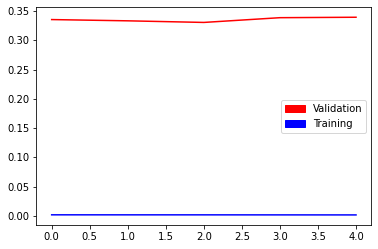

# EPOCH 6 / 100


100%|███████████████████████████████████████████| 49/49 [00:35<00:00,  1.37it/s]


# EPOCH 7 / 100


100%|███████████████████████████████████████████| 49/49 [00:35<00:00,  1.39it/s]


# EPOCH 8 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.42it/s]


# EPOCH 9 / 100


100%|███████████████████████████████████████████| 49/49 [00:36<00:00,  1.35it/s]


# EPOCH 10 / 100


100%|███████████████████████████████████████████| 49/49 [00:37<00:00,  1.30it/s]


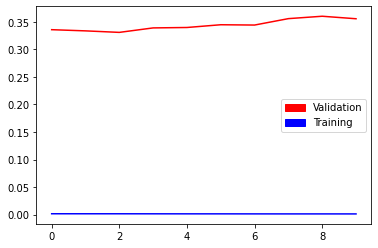

# EPOCH 11 / 100


100%|███████████████████████████████████████████| 49/49 [00:35<00:00,  1.39it/s]


# EPOCH 12 / 100


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 13 / 100


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 14 / 100


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 15 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


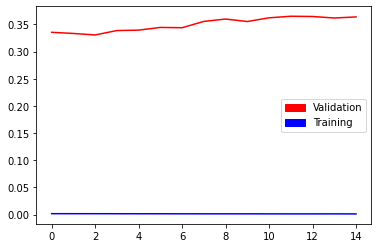

# EPOCH 16 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 17 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.69it/s]


# EPOCH 18 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


# EPOCH 19 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


# EPOCH 20 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


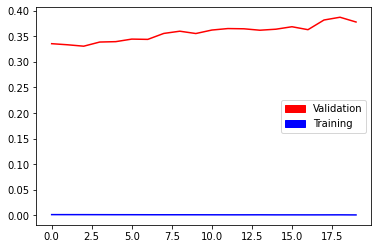

# EPOCH 21 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 22 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.69it/s]


# EPOCH 23 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


# EPOCH 24 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]


# EPOCH 25 / 100


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


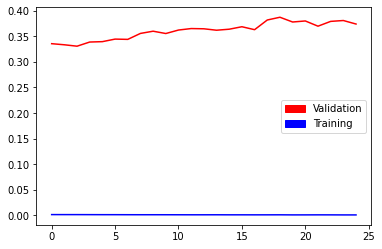

# EPOCH 26 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


# EPOCH 27 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


# EPOCH 28 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.63it/s]


# EPOCH 29 / 100


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.69it/s]


# EPOCH 30 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]


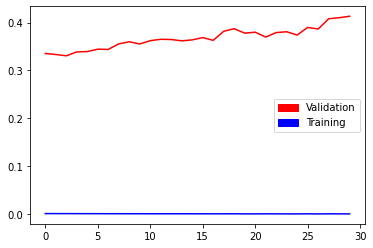

# EPOCH 31 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 32 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]


# EPOCH 33 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


# EPOCH 34 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]


# EPOCH 35 / 100


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


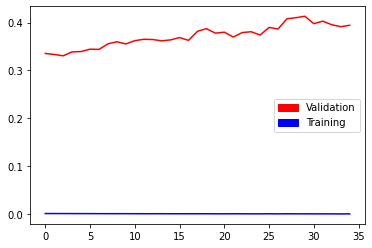

# EPOCH 36 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


# EPOCH 37 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.60it/s]


# EPOCH 38 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


# EPOCH 39 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


# EPOCH 40 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


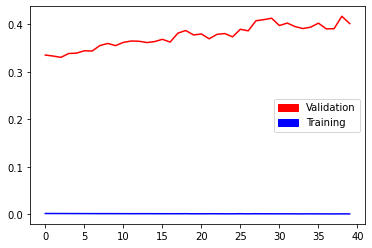

# EPOCH 41 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


# EPOCH 42 / 100


 96%|█████████████████████████████████████████▏ | 47/49 [00:27<00:00,  8.94it/s]

In [ ]:
# V-Net-1
normalization = 'groupnorm'
blocknum = 1
avg_pool = 3
dropout_rate = 0.
optim_class = optim.AdamW
lds = True
fds = False
start_update = 0

# weight_filename = 'pretrained/230527_vnet-{}'.format(blocknum)
weight_filename = 'pretrained/230614_vnet-{}'.format(blocknum)
if lds:
    weight_filename += '+lds'
if fds:
    weight_filename += '+fds'

### VNet pretrained model 가져오기
set_seed()

out_size = 2 ** blocknum
out_size = 192 // out_size
out_size = out_size // avg_pool
num_fc = [out_size * out_size * out_size,30,16,4]
net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                fc_features=[*num_fc], dropout_p=dropout_rate, fds=fds)
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/seg_2304_vnetencoder-{}_{}_bestmodel'.format(blocknum, img_size)), strict=False)
net.cuda()

### Parameter freeze X
#     for i, [name, param] in enumerate(net.named_parameters()):
#         if 'encoder' in name:
#             param.requires_grad = False

### W&B 설정
wandb.init(
    project='202305-WMHvolPredRunAll',
    config={"model": "VNet-{}".format(blocknum),
            "lr": lr, "epochs": num_epochs, "batch_size": batch_size,
            "cost_function": "mse", "optimizer": optim_class.__name__, "weight_decay": weight_decay,
            "dropout": dropout_rate,
            "fds": fds, "lds": lds},
    notes='train with %d data'%(len(train_set)))
wandb.watch(net)

### 학습 시작
train_losses = []
validation_losses = []
min_valid_loss = 1.0

optimizer = optim_class(net.parameters(), lr=lr, weight_decay=weight_decay)
criterion1 = nn.MSELoss()
criterion2 = nn.L1Loss()

set_seed()
for epoch in range(num_epochs):
    # train set
    augment = get_augmentation_transform()
    train_set.transform = tio.transforms.Compose([preprocess, augment])
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

    print('# EPOCH %d / %d'%(epoch+1, num_epochs))

    preds_t, truths_t, mse_t, mae_t = train(net, train_loader, optimizer, epoch=epoch, lds=lds, fds=fds)
    preds_v, truths_v, mse_v, mae_v = valid(net, test_loader)

    train_p, _ = pearsonr(preds_t, truths_t)
    train_s, _ = spearmanr(preds_t, truths_t)
    train_mae = mae_t / len(train_loader)
    train_mse = mse_t / len(train_loader)

    valid_p, _ = pearsonr(preds_v, truths_v)
    valid_s, _ = spearmanr(preds_v, truths_v)
    valid_mae = mae_v / len(test_loader)
    valid_mse = mse_v / len(test_loader)

    if min_valid_loss > valid_mse:
        min_valid_loss = valid_mse
        torch.save(net.state_dict(), weight_filename)

    train_losses.append(train_mse)
    validation_losses.append(valid_mse)
    if (epoch+1)%5 == 0:
        # loss curve
        plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
        red_patch = mpatches.Patch(color='red', label='Validation')
        blue_patch = mpatches.Patch(color='blue', label='Training')
        plt.legend(handles=[red_patch, blue_patch])
        plt.show()

    wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
               "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
wandb.finish()

In [ ]:
# V-Net-1
normalization = 'groupnorm'
blocknum = 1
avg_pool = 3
dropout_rate = 0.
optim_class = optim.AdamW
lds = True
fds = True
start_update = 0

# weight_filename = 'pretrained/230527_vnet-{}'.format(blocknum)
weight_filename = 'pretrained/230614_vnet-{}'.format(blocknum)
if lds:
    weight_filename += '+lds'
if fds:
    weight_filename += '+fds'

### VNet pretrained model 가져오기
set_seed()

out_size = 2 ** blocknum
out_size = 192 // out_size
out_size = out_size // avg_pool
num_fc = [out_size * out_size * out_size,30,16,4]
net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                fc_features=[*num_fc], dropout_p=dropout_rate, fds=fds)
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/seg_2304_vnetencoder-{}_{}_bestmodel'.format(blocknum, img_size)), strict=False)
net.cuda()

### Parameter freeze X
#     for i, [name, param] in enumerate(net.named_parameters()):
#         if 'encoder' in name:
#             param.requires_grad = False

### W&B 설정
wandb.init(
    project='202305-WMHvolPredRunAll',
    config={"model": "VNet-{}".format(blocknum),
            "lr": lr, "epochs": num_epochs, "batch_size": batch_size,
            "cost_function": "mse", "optimizer": optim_class.__name__, "weight_decay": weight_decay,
            "dropout": dropout_rate,
            "fds": fds, "lds": lds},
    notes='train with %d data'%(len(train_set)))
wandb.watch(net)

### 학습 시작
train_losses = []
validation_losses = []
min_valid_loss = 1.0

optimizer = optim_class(net.parameters(), lr=lr, weight_decay=weight_decay)
criterion1 = nn.MSELoss()
criterion2 = nn.L1Loss()

set_seed()
for epoch in range(num_epochs):
    # train set
    augment = get_augmentation_transform()
    train_set.transform = tio.transforms.Compose([preprocess, augment])
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

    print('# EPOCH %d / %d'%(epoch+1, num_epochs))

    preds_t, truths_t, mse_t, mae_t = train(net, train_loader, optimizer, epoch=epoch, lds=lds, fds=fds)
    preds_v, truths_v, mse_v, mae_v = valid(net, test_loader)

    train_p, _ = pearsonr(preds_t, truths_t)
    train_s, _ = spearmanr(preds_t, truths_t)
    train_mae = mae_t / len(train_loader)
    train_mse = mse_t / len(train_loader)

    valid_p, _ = pearsonr(preds_v, truths_v)
    valid_s, _ = spearmanr(preds_v, truths_v)
    valid_mae = mae_v / len(test_loader)
    valid_mse = mse_v / len(test_loader)

    if min_valid_loss > valid_mse:
        min_valid_loss = valid_mse
        torch.save(net.state_dict(), weight_filename)

    train_losses.append(train_mse)
    validation_losses.append(valid_mse)
    if (epoch+1)%5 == 0:
        # loss curve
        plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
        red_patch = mpatches.Patch(color='red', label='Validation')
        blue_patch = mpatches.Patch(color='blue', label='Training')
        plt.legend(handles=[red_patch, blue_patch])
        plt.show()

    wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
               "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
wandb.finish()

# EPOCH 1 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


# EPOCH 2 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 3 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


# EPOCH 4 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]


# EPOCH 5 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


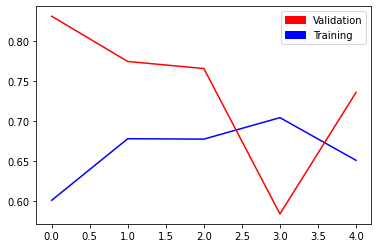

# EPOCH 6 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


# EPOCH 7 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.59it/s]


# EPOCH 8 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


# EPOCH 9 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


# EPOCH 10 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


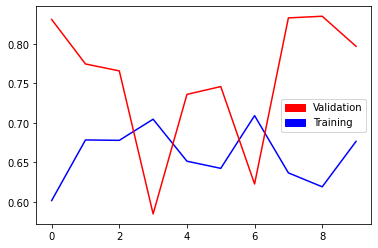

# EPOCH 11 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


# EPOCH 12 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


# EPOCH 13 / 100


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 14 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]


# EPOCH 15 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


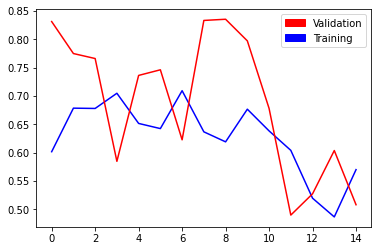

# EPOCH 16 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 17 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 18 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 19 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


# EPOCH 20 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


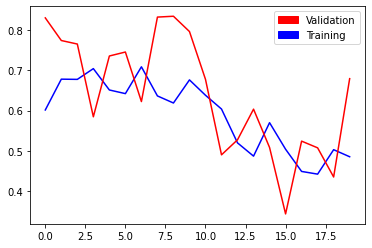

# EPOCH 21 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 22 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


# EPOCH 23 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s]


# EPOCH 24 / 100


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 25 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.69it/s]


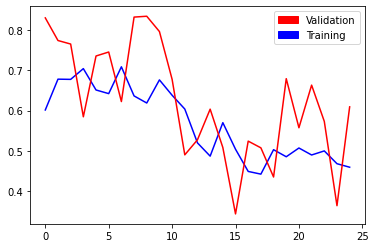

# EPOCH 26 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


# EPOCH 27 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


# EPOCH 28 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 29 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 30 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


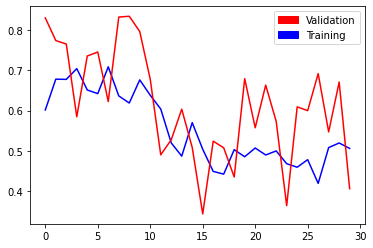

# EPOCH 31 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s]


# EPOCH 32 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s]


# EPOCH 33 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.60it/s]


# EPOCH 34 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


# EPOCH 35 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


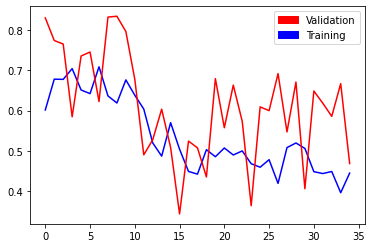

# EPOCH 36 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


# EPOCH 37 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s]


# EPOCH 38 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.59it/s]


# EPOCH 39 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


# EPOCH 40 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.60it/s]


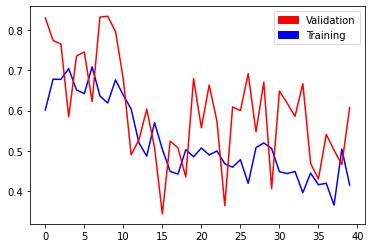

# EPOCH 41 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.63it/s]


# EPOCH 42 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 43 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 44 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 45 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


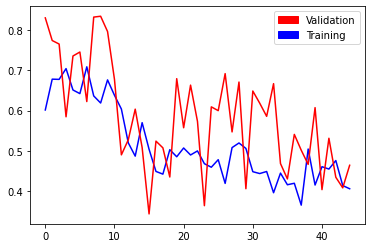

# EPOCH 46 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 47 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


# EPOCH 48 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


# EPOCH 49 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.59it/s]


# EPOCH 50 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


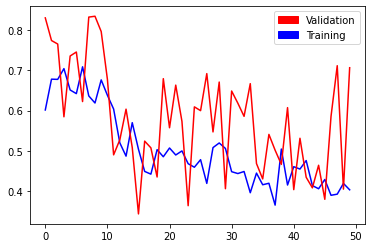

# EPOCH 51 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


# EPOCH 52 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


# EPOCH 53 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.60it/s]


# EPOCH 54 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s]


# EPOCH 55 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


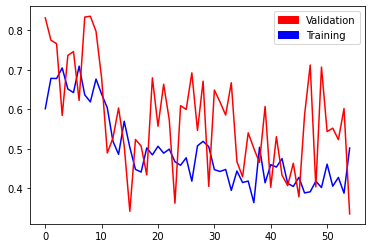

# EPOCH 56 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.56it/s]


# EPOCH 57 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s]


# EPOCH 58 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


# EPOCH 59 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.59it/s]


# EPOCH 60 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


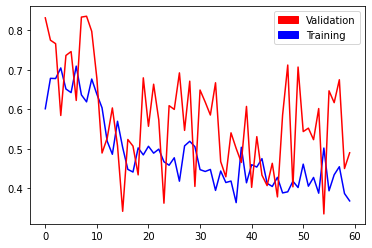

# EPOCH 61 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


# EPOCH 62 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


# EPOCH 63 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


# EPOCH 64 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 65 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.60it/s]


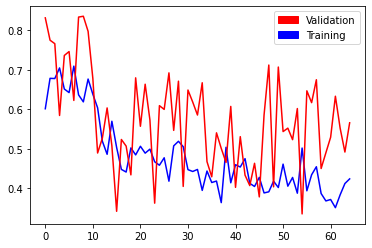

# EPOCH 66 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.58it/s]


# EPOCH 67 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


# EPOCH 68 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


# EPOCH 69 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.60it/s]


# EPOCH 70 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


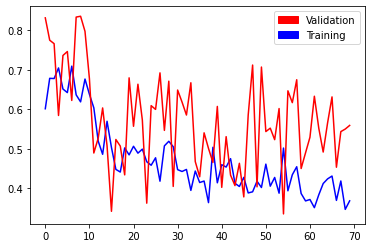

# EPOCH 71 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


# EPOCH 72 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 73 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s]


# EPOCH 74 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]


# EPOCH 75 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]


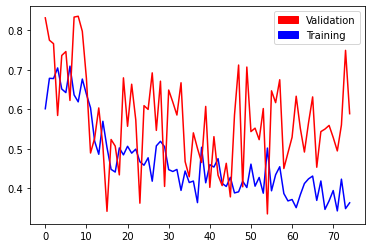

# EPOCH 76 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]


# EPOCH 77 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 78 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.63it/s]


# EPOCH 79 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s]


# EPOCH 80 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


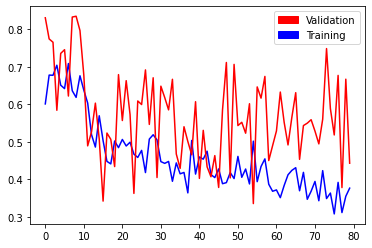

# EPOCH 81 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 82 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


# EPOCH 83 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 84 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 85 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]


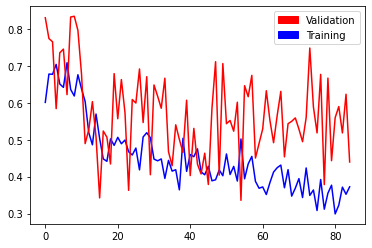

# EPOCH 86 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


# EPOCH 87 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.63it/s]


# EPOCH 88 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]


# EPOCH 89 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 90 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


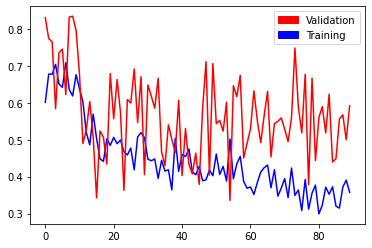

# EPOCH 91 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


# EPOCH 92 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 93 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.60it/s]


# EPOCH 94 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]


# EPOCH 95 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


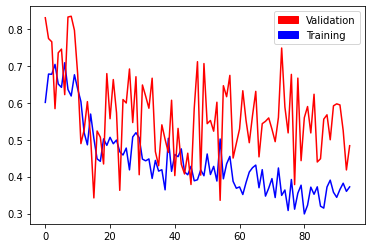

# EPOCH 96 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


# EPOCH 97 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s]


# EPOCH 98 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 99 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.63it/s]


# EPOCH 100 / 100


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


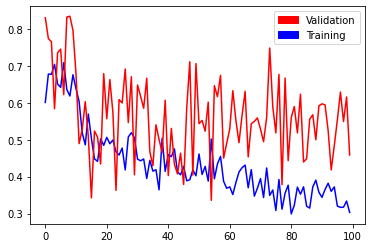

train_mae,█████▇▇█▇▇▇▇▇▇▇▆▆▅▅▅▅▅▄▄▄▄▃▃▃▂▃▂▂▂▂▂▂▁▁▁
train_pearson,▁▃▄▄▄▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇█▇█▇████
train_rank,▇█▇▇▇▅▅▄▅▅▄▅▄▃▃▅▄▃▃▃▄▃▃▃▂▃▂▂▂▂▃▂▁▂▁▃▂▂▁▁
train_spearman,▁▄▄▄▄▄▅▆▇▇▇▇▇▇▇▇█▇▇▇▇██▇████████████████
valid_mae,▆▆▆▆▆▆▇███▇▇▇▇▇▆▆▅▄▄▄▅▄▃▄▃▂▄▃▂▃▂▃▁▂▂▃▂▅▂
valid_pearson,▁▅▅▅▅▆▇▇▇▇▇▇████████████████████████████
valid_rank,█▇▇█▆▄▁▃▄▄▅▄▅▆▂▃▂▂▂▂▄▅▅▃▄▃▃▄▃▇▆▆▅▅▄▃▅▂▅▃
valid_spearman,▁▅▅▅▅▆▇▇▇█▇██████████████████████▇▇██▇██
train_mae,0.26249
train_pearson,0.64184
train_rank,0.30305


In [38]:
from models.ranking_loss import *

# V-Net-1 + RankingLoss
normalization = 'groupnorm'
blocknum = 1
dropout_rate = 0.
optim_class = optim.AdamW
lds = False
fds = False
start_update = 0

weight_filename = 'pretrained/230527_vnet-{}'.format(blocknum)
weight_filename += '+rankingloss'

### VNet pretrained model 가져오기
set_seed()

out_size = 2 ** blocknum
out_size = 192 // out_size
num_fc = [out_size * out_size * out_size,30,16,4]
net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                fc_features=[*num_fc], dropout_p=dropout_rate, fds=fds)
net.conv_out = nn.Conv3d(net.n_filters, 1, 1, padding=0)
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/seg_2304_vnetencoder-{}_{}_bestmodel'.format(blocknum, img_size)), strict=False)
net.cuda()

### Parameter freeze X
#     for i, [name, param] in enumerate(net.named_parameters()):
#         if 'encoder' in name:
#             param.requires_grad = False

### W&B 설정
wandb.init(
    project='202305-WMHvolPredRunAll',
    config={"model": "VNet-{}".format(blocknum),
            "lr": lr, "epochs": num_epochs, "batch_size": batch_size,
            "cost_function": "ranking_loss", "optimizer": optim_class.__name__, "weight_decay": weight_decay,
            "dropout": dropout_rate,
            "fds": fds, "lds": lds},
    notes='train with %d data'%(len(train_set)))
wandb.watch(net)

### 학습 시작
train_losses = []
validation_losses = []
min_valid_loss = 1.0

optimizer = optim_class(net.parameters(), lr=lr, weight_decay=weight_decay)
criterion1 = rank_difference_loss('sodeep/weights/best_model_gruc.pth.tar')
# criterion1 = nn.MSELoss()
criterion2 = nn.L1Loss()

set_seed()
for epoch in range(num_epochs):
    # train set
    augment = get_augmentation_transform()
    train_set.transform = tio.transforms.Compose([preprocess, augment])
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

    print('# EPOCH %d / %d'%(epoch+1, num_epochs))

    preds_t, truths_t, mse_t, mae_t = train(net, train_loader, optimizer, epoch=epoch, lds=lds, fds=fds)
    preds_v, truths_v, mse_v, mae_v = valid(net, test_loader)

    train_p, _ = pearsonr(preds_t, truths_t)
    train_s, _ = spearmanr(preds_t, truths_t)
    train_mae = mae_t / len(train_loader)
    train_mse = mse_t / len(train_loader)

    valid_p, _ = pearsonr(preds_v, truths_v)
    valid_s, _ = spearmanr(preds_v, truths_v)
    valid_mae = mae_v / len(test_loader)
    valid_mse = mse_v / len(test_loader)

    if min_valid_loss > valid_mse:
        min_valid_loss = valid_mse
        torch.save(net.state_dict(), weight_filename)

    train_losses.append(train_mse)
    validation_losses.append(valid_mse)
    if (epoch+1)%5 == 0:
        # loss curve
        plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
        red_patch = mpatches.Patch(color='red', label='Validation')
        blue_patch = mpatches.Patch(color='blue', label='Training')
        plt.legend(handles=[red_patch, blue_patch])
        plt.show()

    wandb.log({"train_mae": train_mae, "train_rank": train_mse, "valid_mae": valid_mae, "valid_rank": valid_mse,
               "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
wandb.finish()

---

In [39]:
# 뇌백질변성 부피 데이터 분포. Fazekas scale[25] 별로 구간을 나눈 결과, 어떤 구간에 데이터가 편향되어 있음을 확인할 수 있다.
paper_df = pd.read_csv('labels/data_975.csv')
paper_df

,FOLDERNAME,Cortical Gray Matter Total Percent Of Icv,Intracranial Volume Total Volume,WMH_GRADE,FL_WMH_VOL_mm3,FL_PVWMH_VOL_mm3,FL_DWMH_VOL_mm3,FL_WMH_VOL_mL,FL_PVWMH_VOL_mL,FL_DWMH_VOL_mL,FL_WMH_VOL_icv,FL_PVWMH_VOL_icv,FL_DWMH_VOL_icv
0,14090110_20180523_095025_MR,30.7874,1412.090,0,337.895020,157.315048,180.579956,0.337895,0.157315,0.180580,0.023929,0.011141,0.012788
1,14152551_20180129_085254_MR,31.9052,1335.478,1,3444.313477,2918.083252,526.229919,3.444313,2.918083,0.526230,0.257909,0.218505,0.039404
2,15168092_20180223_091548_MR,30.3495,1610.208,1,6242.568359,5591.169434,651.398438,6.242568,5.591169,0.651398,0.387687,0.347233,0.040454
3,16657951_20180529_103505_MR,30.7348,1717.096,0,2463.921387,2174.765381,289.156250,2.463921,2.174765,0.289156,0.143494,0.126654,0.016840
4,16965739_20180419_103601_MR,30.3336,1428.555,1,8906.025391,6842.096680,2063.929199,8.906025,6.842097,2.063929,0.623429,0.478952,0.144477
...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,test_167,34.3623,1642.426,1,1783.655396,1770.361084,13.294326,1.783655,1.770361,0.013294,0.108599,0.107789,0.000809
971,test_168,29.4961,1451.734,0,510.719971,464.190186,46.529804,0.510720,0.464190,0.046530,0.035180,0.031975,0.003205
972,test_169,33.0468,1434.458,1,5451.742188,4030.367432,1421.374634,5.451742,4.030367,1.421375,0.380056,0.280968,0.099088
973,test_170,37.4587,1635.667,0,466.405945,460.866638,5.539262,0.466406,0.460867,0.005539,0.028515,0.028176,0.000339


In [40]:
paper_df = pd.read_csv('labels/data_975.csv', index_col=0)['WMH_GRADE']
paper_df

FOLDERNAME
14090110_20180523_095025_MR    0
14152551_20180129_085254_MR    1
15168092_20180223_091548_MR    1
16657951_20180529_103505_MR    0
16965739_20180419_103601_MR    1
                              ..
test_167                       1
test_168                       0
test_169                       1
test_170                       0
test_171                       1
Name: WMH_GRADE, Length: 975, dtype: int64

Text(0, 0.5, 'No. of subjects')

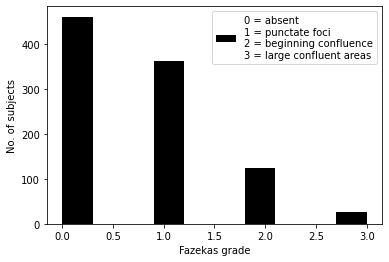

In [60]:
# 0 = absent
# 1 = punctate foci
# 2 = beginning confluence
# 3 = large confluent areas
paper_df_label = '0 = absent\n1 = punctate foci\n2 = beginning confluence\n3 = large confluent areas'
paper_df.hist(grid=False, color='black', label=paper_df_label)
plt.legend()
plt.xlabel('Fazekas grade'); plt.ylabel('No. of subjects')

---

In [61]:
# wandb.finish()   # wandb error 방지

In [62]:
"""https://gmnam.tistory.com/302"""
import seaborn as sns
from models.regression_loss import RMSELoss

def evaluate(model, data_loader, title='', line=False, legend=False):
    mae_loss = nn.L1Loss()
    rmse_loss = RMSELoss()
    total_mae, total_rmse = 0, 0
    
    model.eval()
    preds, truths = np.array([]), np.array([])
    with torch.no_grad():
        for inputs, labels, _ in tqdm(data_loader):
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
            output = model(inputs)
            
            mae = mae_loss(output, labels)
            rmse = rmse_loss(output, labels)
            
            pred = output.detach().cpu().numpy()
            truth = labels.detach().cpu().numpy()
            preds = np.append(preds, pred.reshape(pred.size), axis=0)
            truths = np.append(truths, truth.reshape(truth.size), axis=0)
            
            total_mae += mae.data.item()
            total_rmse += rmse.data.item()
        
    # Get metrics
    mae = total_mae / len(data_loader)
    rmse = total_rmse / len(data_loader)
    pearson, pearson_p = pearsonr(preds, truths)
    spearman, spearman_p = spearmanr(preds, truths)
#     r2 = pearson**2
    ssr = np.sum((preds - np.mean(truths))**2)  # sum of square of regression
    sse = np.sum((truths - preds)**2)  # sum of square of errors
    sst = ssr + sse  # total sum of squares
    r2 = ssr/sst  # R-Squared = SSR/SST = 1-(SSE/SST)
        
    return mae, rmse, r2, pearson, spearman, truths

100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.320	0.408	0.167		0.417		0.468



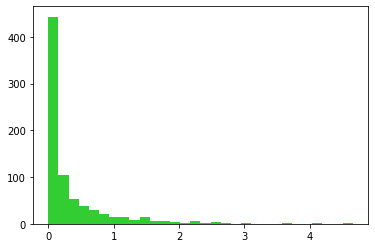

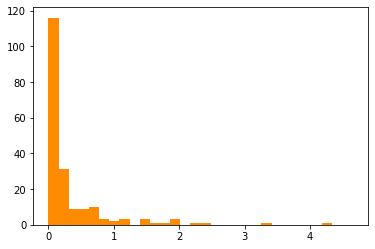

100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.295	0.382	0.216		0.426		0.471



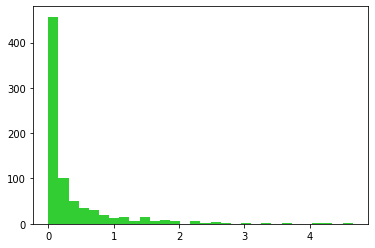

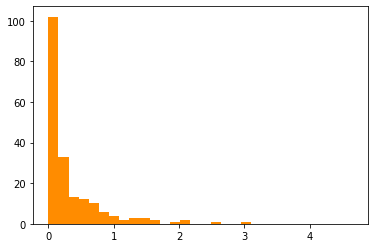

100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.318	0.423	0.122		0.431		0.402



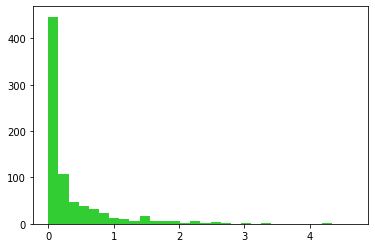

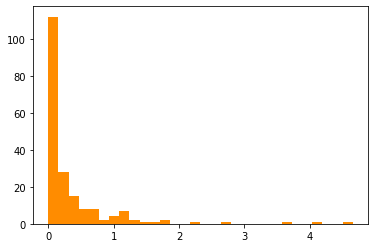

100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.335	0.442	0.141		0.419		0.403



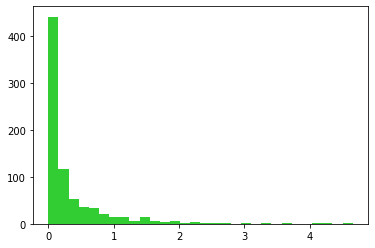

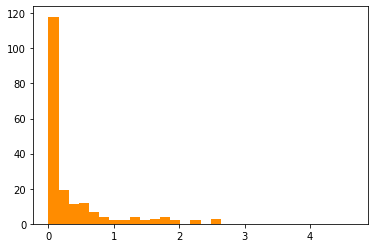

100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.344	0.437	0.169		0.368		0.400



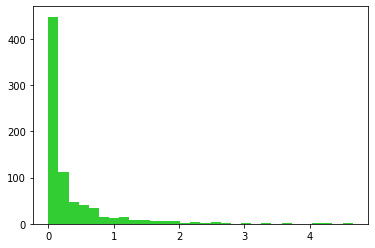

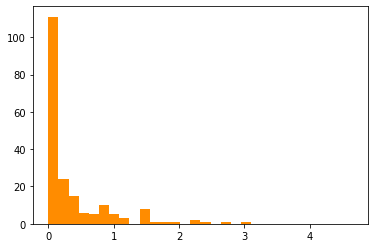

In [63]:
# V-Net-1 5-Fold cross validation: Evalutation
normalization = 'groupnorm'
blocknum = 1
dropout_rate = 0.
optim_class = optim.AdamW
fds = False
start_update = 0

# 5-Fold cross validation
set_seed()
splits = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

for fold, (train_idx, valid_idx) in enumerate(splits.split(np.arange(len(dataset)))):
    weight_filename = 'pretrained/230525_vnet-{}-5FoldCV-fold{}'.format(blocknum, fold+1)
    if fds:
        weight_filename += '+fds'
        
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    ### trained model 가져오기
    set_seed()

    out_size = 2 ** blocknum
    out_size = 192 // out_size
    num_fc = [out_size * out_size * out_size,30,16,4]
    net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                    fc_features=[*num_fc], dropout_p=dropout_rate, fds=fds)
    net.conv_out = nn.Conv3d(net.n_filters, 1, 1, padding=0)
    net = torch.nn.DataParallel(net, device_ids=[0, 1])
    net.load_state_dict(torch.load(weight_filename))
    net.cuda()

    ### Parameter freeze X
    #     for i, [name, param] in enumerate(net.named_parameters()):
    #         if 'encoder' in name:
    #             param.requires_grad = False

    set_seed()
    for epoch in range(1):
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=16)
        valid_loader = DataLoader(dataset, batch_size=test_batch_size, sampler=valid_sampler, num_workers=16)
         
        _, _, _, _, _, subset_t = evaluate(net, train_loader)
        mae, rmse, r2, pcc, srcc, subset_v = evaluate(net, valid_loader)        
        
        text = "------------------------------------------------------------------------------------------\n"
        text += "MAE\tRMSE\tR-Squared\tPearson's r\tSpearman's r\t\n"
        text += "==========================================================================================\n"
        text += "{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}\t\t{:.3f}\n".format(mae, rmse, r2, pcc, srcc)
        print(text)
    
        y_min = min(subset_t.min(), subset_v.min())
        y_max = max(subset_t.max(), subset_v.max())
        
        plt.hist(subset_t, bins=30, range=(y_min, y_max), color='limegreen')
        plt.show()
        
        plt.hist(subset_v, bins=30, range=(y_min, y_max), color='darkorange')
        plt.show()
        
        plt.close()

100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.316	0.410	0.243		0.454		0.460



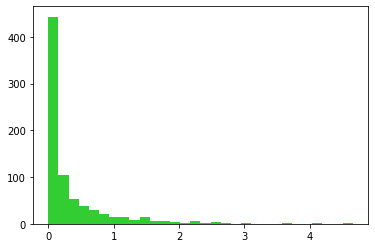

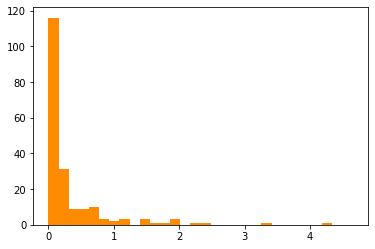

100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.69it/s]

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.314	0.409	0.423		0.472		0.505



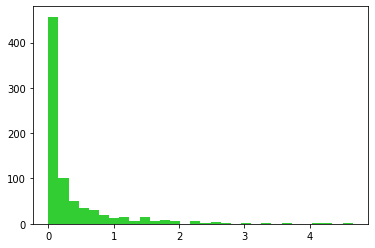

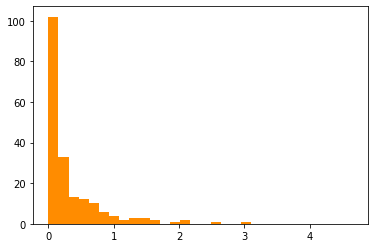

100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.311	0.409	0.218		0.500		0.426



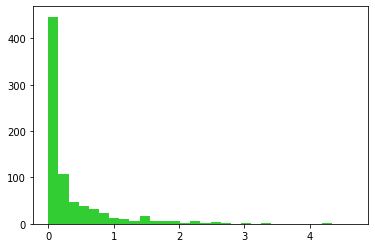

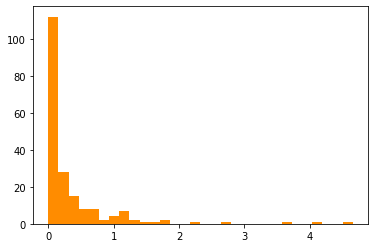

100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.302	0.419	0.278		0.474		0.513



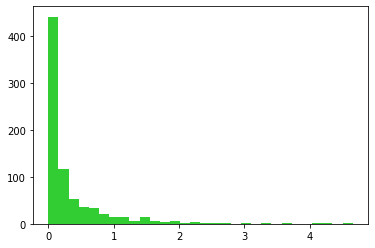

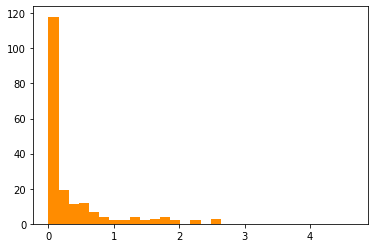

100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.318	0.430	0.296		0.419		0.452



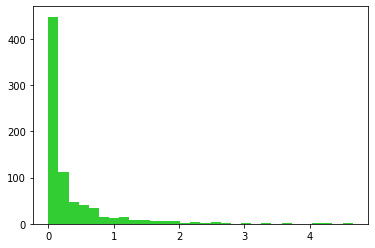

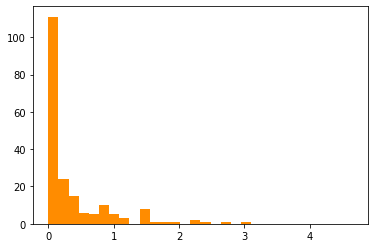

In [64]:
# V-Net-2 5-Fold cross validation: Evalutation
normalization = 'groupnorm'
blocknum = 2
dropout_rate = 0.
optim_class = optim.AdamW
fds = False
start_update = 0

# 5-Fold cross validation
set_seed()
splits = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

for fold, (train_idx, valid_idx) in enumerate(splits.split(np.arange(len(dataset)))):
    weight_filename = 'pretrained/230525_vnet-{}-5FoldCV-fold{}'.format(blocknum, fold+1)
    if fds:
        weight_filename += '+fds'
        
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    ### trained model 가져오기
    set_seed()

    out_size = 2 ** blocknum
    out_size = 192 // out_size
    num_fc = [out_size * out_size * out_size,30,16,4]
    net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                    fc_features=[*num_fc], dropout_p=dropout_rate, fds=fds)
    net.conv_out = nn.Conv3d(net.n_filters, 1, 1, padding=0)
    net = torch.nn.DataParallel(net, device_ids=[0, 1])
    net.load_state_dict(torch.load(weight_filename))
    net.cuda()

    ### Parameter freeze X
    #     for i, [name, param] in enumerate(net.named_parameters()):
    #         if 'encoder' in name:
    #             param.requires_grad = False

    set_seed()
    for epoch in range(1):
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=16)
        valid_loader = DataLoader(dataset, batch_size=test_batch_size, sampler=valid_sampler, num_workers=16)
         
        _, _, _, _, _, subset_t = evaluate(net, train_loader)
        mae, rmse, r2, pcc, srcc, subset_v = evaluate(net, valid_loader)        
        
        text = "------------------------------------------------------------------------------------------\n"
        text += "MAE\tRMSE\tR-Squared\tPearson's r\tSpearman's r\t\n"
        text += "==========================================================================================\n"
        text += "{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}\t\t{:.3f}\n".format(mae, rmse, r2, pcc, srcc)
        print(text)
    
        y_min = min(subset_t.min(), subset_v.min())
        y_max = max(subset_t.max(), subset_v.max())
        
        plt.hist(subset_t, bins=30, range=(y_min, y_max), color='limegreen')
        plt.show()
        
        plt.hist(subset_v, bins=30, range=(y_min, y_max), color='darkorange')
        plt.show()
        
        plt.close()

100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.356	0.427	0.196		0.463		0.433



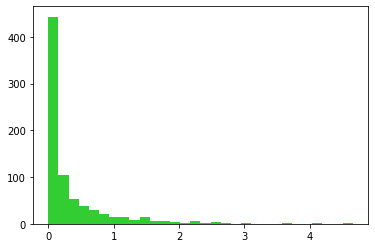

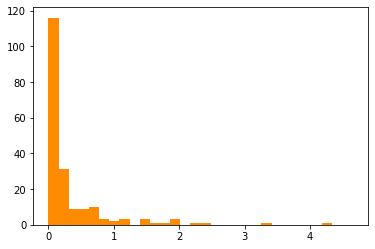

100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s]

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.334	0.411	0.265		0.420		0.455



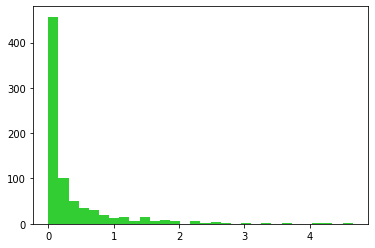

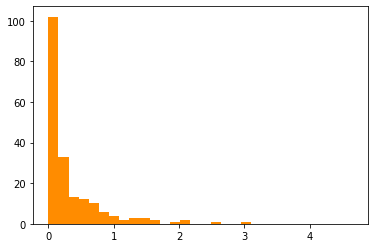

100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.336	0.423	0.123		0.490		0.436



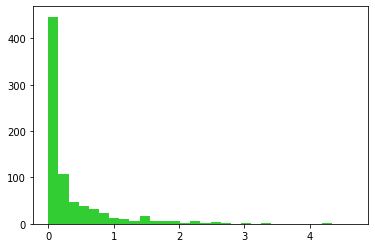

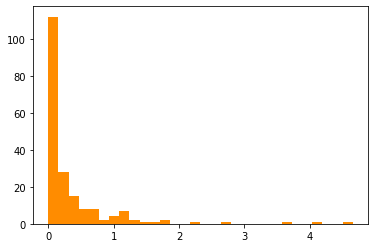

100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.352	0.441	0.133		0.457		0.433



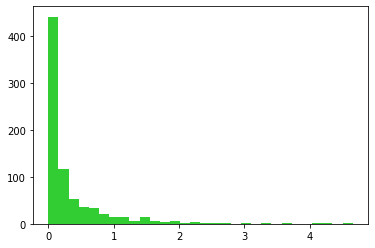

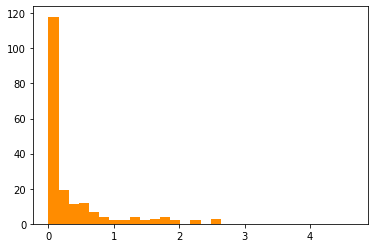

100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.355	0.429	0.170		0.453		0.472



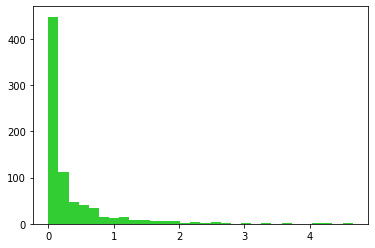

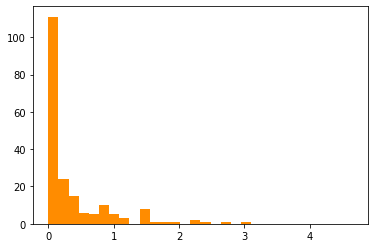

In [65]:
# V-Net-3 5-Fold cross validation: Evalutation
normalization = 'groupnorm'
blocknum = 3
dropout_rate = 0.
optim_class = optim.AdamW
fds = False
start_update = 0

# 5-Fold cross validation
set_seed()
splits = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

for fold, (train_idx, valid_idx) in enumerate(splits.split(np.arange(len(dataset)))):
    weight_filename = 'pretrained/230525_vnet-{}-5FoldCV-fold{}'.format(blocknum, fold+1)
    if fds:
        weight_filename += '+fds'
        
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    ### trained model 가져오기
    set_seed()

    out_size = 2 ** blocknum
    out_size = 192 // out_size
    num_fc = [out_size * out_size * out_size,30,16,4]
    net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                    fc_features=[*num_fc], dropout_p=dropout_rate, fds=fds)
    net.conv_out = nn.Conv3d(net.n_filters, 1, 1, padding=0)
    net = torch.nn.DataParallel(net, device_ids=[0, 1])
    net.load_state_dict(torch.load(weight_filename))
    net.cuda()

    ### Parameter freeze X
    #     for i, [name, param] in enumerate(net.named_parameters()):
    #         if 'encoder' in name:
    #             param.requires_grad = False

    set_seed()
    for epoch in range(1):
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=16)
        valid_loader = DataLoader(dataset, batch_size=test_batch_size, sampler=valid_sampler, num_workers=16)
         
        _, _, _, _, _, subset_t = evaluate(net, train_loader)
        mae, rmse, r2, pcc, srcc, subset_v = evaluate(net, valid_loader)        
        
        text = "------------------------------------------------------------------------------------------\n"
        text += "MAE\tRMSE\tR-Squared\tPearson's r\tSpearman's r\t\n"
        text += "==========================================================================================\n"
        text += "{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}\t\t{:.3f}\n".format(mae, rmse, r2, pcc, srcc)
        print(text)
    
        y_min = min(subset_t.min(), subset_v.min())
        y_max = max(subset_t.max(), subset_v.max())
        
        plt.hist(subset_t, bins=30, range=(y_min, y_max), color='limegreen')
        plt.show()
        
        plt.hist(subset_v, bins=30, range=(y_min, y_max), color='darkorange')
        plt.show()
        
        plt.close()

100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.278	0.411	0.121		0.101		0.012



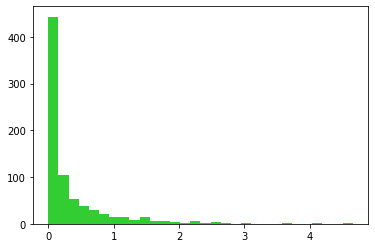

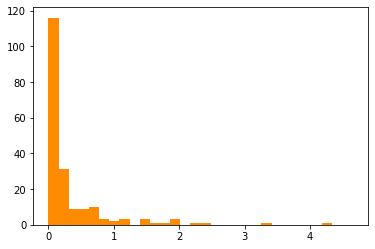

100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.59it/s]

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.341	0.482	0.246		-0.058		0.132



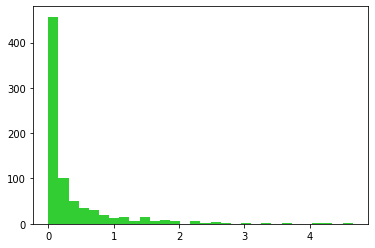

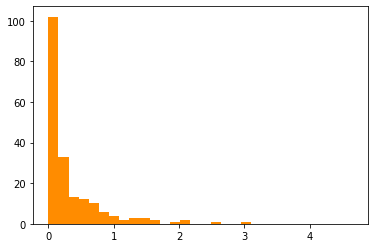

100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.318	0.464	0.131		0.068		0.100



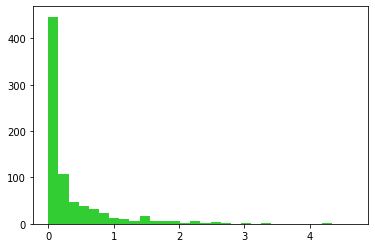

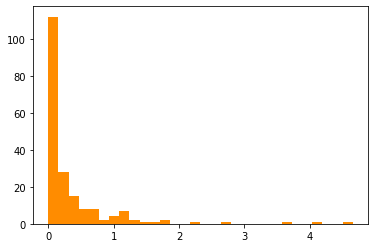

100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.355	0.536	0.221		0.130		0.098



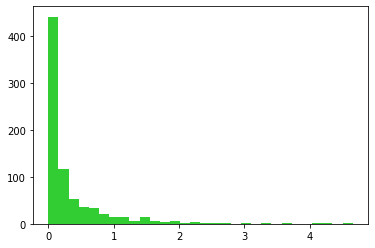

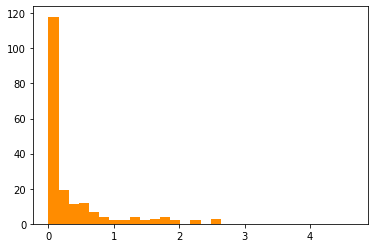

100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.360	0.508	0.231		0.041		0.039



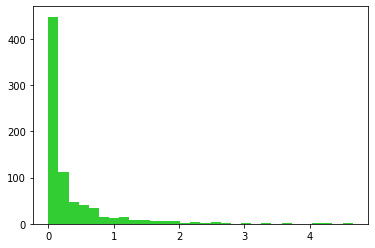

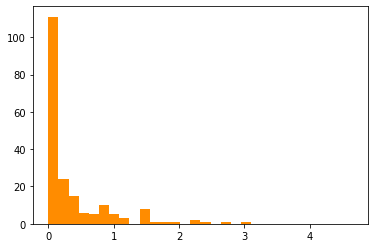

In [66]:
# V-Net-4 5-Fold cross validation: Evalutation
normalization = 'groupnorm'
blocknum = 4
dropout_rate = 0.
optim_class = optim.AdamW
fds = False
start_update = 0

# 5-Fold cross validation
set_seed()
splits = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

for fold, (train_idx, valid_idx) in enumerate(splits.split(np.arange(len(dataset)))):
    weight_filename = 'pretrained/230525_vnet-{}-5FoldCV-fold{}'.format(blocknum, fold+1)
    if fds:
        weight_filename += '+fds'
        
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    ### trained model 가져오기
    set_seed()

    out_size = 2 ** blocknum
    out_size = 192 // out_size
    num_fc = [out_size * out_size * out_size,30,16,4]
    net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                    fc_features=[*num_fc], dropout_p=dropout_rate, fds=fds)
    net.conv_out = nn.Conv3d(net.n_filters, 1, 1, padding=0)
    net = torch.nn.DataParallel(net, device_ids=[0, 1])
    net.load_state_dict(torch.load(weight_filename))
    net.cuda()

    ### Parameter freeze X
    #     for i, [name, param] in enumerate(net.named_parameters()):
    #         if 'encoder' in name:
    #             param.requires_grad = False

    set_seed()
    for epoch in range(1):
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=16)
        valid_loader = DataLoader(dataset, batch_size=test_batch_size, sampler=valid_sampler, num_workers=16)
         
        _, _, _, _, _, subset_t = evaluate(net, train_loader)
        mae, rmse, r2, pcc, srcc, subset_v = evaluate(net, valid_loader)        
        
        text = "------------------------------------------------------------------------------------------\n"
        text += "MAE\tRMSE\tR-Squared\tPearson's r\tSpearman's r\t\n"
        text += "==========================================================================================\n"
        text += "{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}\t\t{:.3f}\n".format(mae, rmse, r2, pcc, srcc)
        print(text)
    
        y_min = min(subset_t.min(), subset_v.min())
        y_max = max(subset_t.max(), subset_v.max())
        
        plt.hist(subset_t, bins=30, range=(y_min, y_max), color='limegreen')
        plt.show()
        
        plt.hist(subset_v, bins=30, range=(y_min, y_max), color='darkorange')
        plt.show()
        
        plt.close()

---

In [67]:
"""https://gmnam.tistory.com/302"""
import seaborn as sns
from models.regression_loss import RMSELoss

def predict(model, data_loader, title='', line=False, legend=False):
    mae_loss = nn.L1Loss()
    rmse_loss = RMSELoss()
    total_mae, total_rmse = 0, 0
    
    model.eval()
    preds, truths = np.array([]), np.array([])
    with torch.no_grad():
        for inputs, labels, _ in tqdm(data_loader):
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
            output = model(inputs)
            
            mae = mae_loss(output, labels)
            rmse = rmse_loss(output, labels)
            
            pred = output.detach().cpu().numpy()
            truth = labels.detach().cpu().numpy()
            preds = np.append(preds, pred.reshape(pred.size), axis=0)
            truths = np.append(truths, truth.reshape(truth.size), axis=0)
            
            total_mae += mae.data.item()
            total_rmse += rmse.data.item()
        
    # Get metrics
    mae = total_mae / len(data_loader)
    rmse = total_rmse / len(data_loader)
    pearson, pearson_p = pearsonr(preds, truths)
    spearman, spearman_p = spearmanr(preds, truths)
#     r2 = pearson**2
    ssr = np.sum((preds - np.mean(truths))**2)  # sum of square of regression
    sse = np.sum((truths - preds)**2)  # sum of square of errors
    sst = ssr + sse  # total sum of squares
    r2 = ssr/sst  # R-Squared = SSR/SST = 1-(SSE/SST)
    
    # For range setting
    _min = truths.min() - 0.5
    _max = truths.max() + 0.5
        
    # Reference line
    x = np.linspace(_min, _max)
    y = x
    plt.plot(x, y, c='gray', ls='--')
    
    # Regression Plot
    
    ## Scatter
    plt.scatter(truths, preds, c='black')
    
    ## Linear Regression Line
    if line:
        m, b = np.polyfit(truths, preds, 1)
        plt.plot(truths, m*truths + b, c='deeppink', label='R2 = {:.3f}')
#     # Regression Plot at once
#     sns.regplot(x=truths, y=preds, ci=None, color='deeppink', label='Pearson r = {:.2f}'.format(pearson))

    if title != '':
        plt.title(title)
    
    plt.axis('square')
    plt.ylabel('Predicted WMH'); plt.xlabel('Ground Truth')
    if legend:
        plt.legend()
    plt.tight_layout()
    plt.xlim([_min, _max])
    plt.ylim([_min, _max])
    plt.show()
    plt.close()
    
    return mae, rmse, r2, pearson, spearman

In [101]:
from models.vnet_encoder_reg import Regressor

VNet-1 + LDS


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.58it/s]


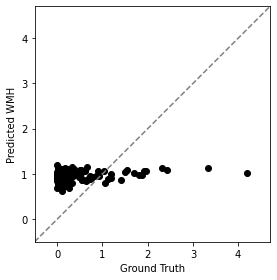

------------------------------------------------------------------------------------------
MAE	RMSE	R2	Pearson's r	Spearman's r	
0.789	0.829	0.369	0.208		0.155
0.79	0.83	0.37	0.21		0.16



In [102]:
print("VNet-1 + LDS")
normalization = 'groupnorm'
blocknum = 1
lds = True
fds = False

weight_filename = 'pretrained/230527_vnet-{}'.format(blocknum)
if lds:
    weight_filename += '+lds'
if fds:
    weight_filename += '+fds'

out_size = 2 ** blocknum
out_size = 192 // out_size
out_size = out_size // avg_pool
num_fc = [out_size * out_size * out_size,30,16,4]
net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                fc_features=[*num_fc], dropout_p=dropout_rate, fds=fds)
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load(weight_filename))
net.cuda()

mae, rmse, r2, pearson, spearman = predict(net, test_loader)
text = "------------------------------------------------------------------------------------------\n"
text += "MAE\tRMSE\tR2\tPearson's r\tSpearman's r\t\n"
text += "==========================================================================================\n"
text += "{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}\n".format(mae, rmse, r2, pearson, spearman)
text += "{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t\t{:.2f}\n".format(mae, rmse, r2, pearson, spearman)
print(text)

VNet-1 + FDS


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.59it/s]


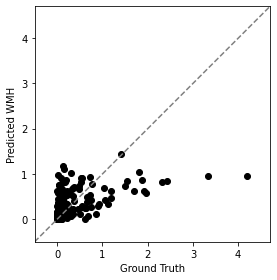

------------------------------------------------------------------------------------------
MAE	RMSE	R2	Pearson's r	Spearman's r	
0.313	0.404	0.246	0.495		0.498
0.31	0.40	0.25	0.50		0.50



In [103]:
print("VNet-1 + FDS")
normalization = 'groupnorm'
blocknum = 1
lds = False
fds = True

weight_filename = 'pretrained/230527_vnet-{}'.format(blocknum)
if lds:
    weight_filename += '+lds'
if fds:
    weight_filename += '+fds'

out_size = 2 ** blocknum
out_size = 192 // out_size
out_size = out_size // avg_pool
num_fc = [out_size * out_size * out_size,30,16,4]
net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                fc_features=[*num_fc], dropout_p=dropout_rate, fds=fds)
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load(weight_filename))
net.cuda()

mae, rmse, r2, pearson, spearman = predict(net, test_loader)
text = "------------------------------------------------------------------------------------------\n"
text += "MAE\tRMSE\tR2\tPearson's r\tSpearman's r\t\n"
text += "==========================================================================================\n"
text += "{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}\n".format(mae, rmse, r2, pearson, spearman)
text += "{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t\t{:.2f}\n".format(mae, rmse, r2, pearson, spearman)
print(text)

VNet-1 + LDS + FDS


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.55it/s]


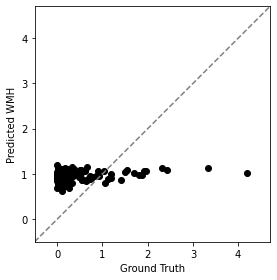

------------------------------------------------------------------------------------------
MAE	RMSE	R2	Pearson's r	Spearman's r	
0.789	0.829	0.369	0.208		0.155
0.79	0.83	0.37	0.21		0.16



In [104]:
print("VNet-1 + LDS + FDS")
normalization = 'groupnorm'
blocknum = 1
lds = True
fds = True

weight_filename = 'pretrained/230527_vnet-{}'.format(blocknum)
if lds:
    weight_filename += '+lds'
if fds:
    weight_filename += '+fds'

out_size = 2 ** blocknum
out_size = 192 // out_size
out_size = out_size // avg_pool
num_fc = [out_size * out_size * out_size,30,16,4]
net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                fc_features=[*num_fc], dropout_p=dropout_rate, fds=fds)
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load(weight_filename))
net.cuda()

mae, rmse, r2, pearson, spearman = predict(net, test_loader)
text = "------------------------------------------------------------------------------------------\n"
text += "MAE\tRMSE\tR2\tPearson's r\tSpearman's r\t\n"
text += "==========================================================================================\n"
text += "{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}\n".format(mae, rmse, r2, pearson, spearman)
text += "{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t\t{:.2f}\n".format(mae, rmse, r2, pearson, spearman)
print(text)

VNet-1 + Ranking loss


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.57it/s]


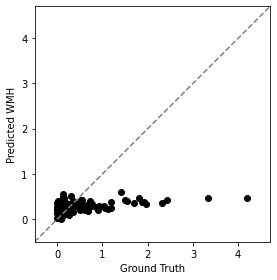

------------------------------------------------------------------------------------------
MAE	RMSE	R2	Pearson's r	Spearman's r	
0.292	0.392	0.047	0.463		0.496
0.29	0.39	0.05	0.46		0.50



In [105]:
print("VNet-1 + Ranking loss")
normalization = 'groupnorm'
blocknum = 1
lds = False
fds = False

weight_filename = 'pretrained/230527_vnet-{}'.format(blocknum)
weight_filename += '+rankingloss'

out_size = 2 ** blocknum
out_size = 192 // out_size
num_fc = [out_size * out_size * out_size,30,16,4]
net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                fc_features=[*num_fc], dropout_p=dropout_rate, fds=fds)
net.conv_out = nn.Conv3d(net.n_filters, 1, 1, padding=0)
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load(weight_filename))
net.cuda()

mae, rmse, r2, pearson, spearman = predict(net, test_loader)
text = "------------------------------------------------------------------------------------------\n"
text += "MAE\tRMSE\tR2\tPearson's r\tSpearman's r\t\n"
text += "==========================================================================================\n"
text += "{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}\n".format(mae, rmse, r2, pearson, spearman)
text += "{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t\t{:.2f}\n".format(mae, rmse, r2, pearson, spearman)
print(text)

In [18]:
import torch
from torch import nn
import torch.nn.functional as F
from models.segmentation.vnet_new import VNet_New
from fds import FDS
import math


class Regressor(VNet_New):

    def __init__(self, n_channels, n_classes=2, n_filters=16, normalization='none', n_blocks=4, out_features=1,
                 fc_features=[512], dropout_p=0., activation_fcn=True,
                 fds=False, bucket_num=100, bucket_start=3, start_update=0, start_smooth=1, kernel='gaussian', ks=9,
                 sigma=1, momentum=0.9):
        super(Regressor, self).__init__(n_channels, n_classes, n_filters, normalization, n_blocks)
        self.activation_fcn = activation_fcn
        self.n_filters = (2 ** n_blocks) * n_filters
        self.feature_extractor = nn.Conv3d(self.n_filters, 1, 1, padding=0)
        self.fc = nn.Sequential()
        n = len(fc_features)
        for i in range(n - 1):
            self.fc.add_module('linear_%d' % (i + 1), nn.Linear(fc_features[i], fc_features[i + 1]))
            self.fc.append(nn.ReLU())
        self.fc.add_module('dropout', nn.Dropout(dropout_p))
        self.fc.add_module('linear_out', nn.Linear(fc_features[n - 1], out_features))
        if fds:
            self.FDS = FDS(
                feature_dim=64, bucket_num=bucket_num, bucket_start=bucket_start,
                start_update=start_update, start_smooth=start_smooth, kernel=kernel, ks=ks, sigma=sigma,
                momentum=momentum
            )
        self.fds = fds
        self.start_smooth = start_smooth

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.kernel_size[2] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, inputs, targets=None, epoch=None):
        x = self.encoder(inputs)
        x = self.feature_extractor(x)
        encoding = x.view(x.size(0), -1)
        encoding_s = encoding

        if self.training and self.fds:
            if epoch >= self.start_smooth:
                encoding_s = self.FDS.smooth(encoding_s, targets, epoch)

        out = self.fc(encoding_s)
        if self.activation_fcn:
            out = F.leaky_relu(out)

        if self.training and self.fds:
            return out, encoding
        return out

VNet-1


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.41it/s]


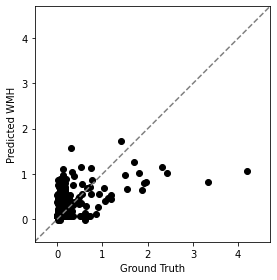

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.322	0.417	0.307		0.486		0.439
0.32	0.42	0.31		0.49		0.44



In [195]:
print("VNet-1")
normalization = 'groupnorm'
blocknum = 1
out_size = 2 ** blocknum
out_size = 192 // out_size
num_fc = [out_size * out_size * out_size,30,16,4]
net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                fc_features=[*num_fc])
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230504_ieie_vnet-{}'.format(blocknum)))
net.cuda()
mae, rmse, r2, pearson, spearman = predict(net, test_loader)
text = "------------------------------------------------------------------------------------------\n"
text += "MAE\tRMSE\tR-Squared\tPearson's r\tSpearman's r\t\n"
text += "==========================================================================================\n"
text += "{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}\t\t{:.3f}\n".format(mae, rmse, r2, pearson, spearman)
text += "{:.2f}\t{:.2f}\t{:.2f}\t\t{:.2f}\t\t{:.2f}\n".format(mae, rmse, r2, pearson, spearman)
print(text)

VNet-1


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.44it/s]


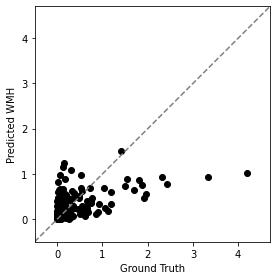

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.292	0.385	0.226		0.522		0.461
0.29	0.38	0.23		0.52		0.46



In [196]:
print("VNet-1")
normalization = 'groupnorm'
blocknum = 1
out_size = 2 ** blocknum
out_size = 192 // out_size
num_fc = [out_size * out_size * out_size,30,16,4]
net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                fc_features=[*num_fc])
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230505_ieie_vnet-{}'.format(blocknum)))
net.cuda()
mae, rmse, r2, pearson, spearman = predict(net, test_loader)
text = "------------------------------------------------------------------------------------------\n"
text += "MAE\tRMSE\tR-Squared\tPearson's r\tSpearman's r\t\n"
text += "==========================================================================================\n"
text += "{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}\t\t{:.3f}\n".format(mae, rmse, r2, pearson, spearman)
text += "{:.2f}\t{:.2f}\t{:.2f}\t\t{:.2f}\t\t{:.2f}\n".format(mae, rmse, r2, pearson, spearman)
print(text)

VNet-1


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.60it/s]


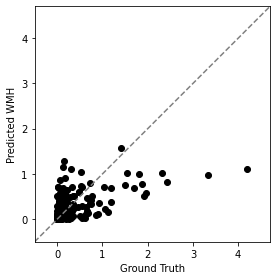

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.304	0.396	0.260		0.519		0.428
0.30	0.40	0.26		0.52		0.43



In [87]:
print("VNet-1")
normalization = 'groupnorm'
blocknum = 1
out_size = 2 ** blocknum
out_size = 192 // out_size
num_fc = [out_size * out_size * out_size,30,16,4]
net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                fc_features=[*num_fc])
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230430_ieie_vnet-{}'.format(blocknum)))
net.cuda()
mae, rmse, r2, pearson, spearman = predict(net, test_loader)
text = "------------------------------------------------------------------------------------------\n"
text += "MAE\tRMSE\tR-Squared\tPearson's r\tSpearman's r\t\n"
text += "==========================================================================================\n"
text += "{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}\t\t{:.3f}\n".format(mae, rmse, r2, pearson, spearman)
text += "{:.2f}\t{:.2f}\t{:.2f}\t\t{:.2f}\t\t{:.2f}\n".format(mae, rmse, r2, pearson, spearman)
print(text)

VNet-2


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


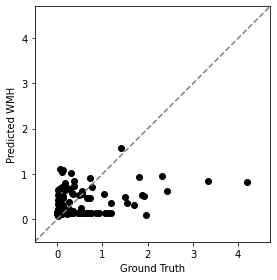

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.293	0.399	0.192		0.411		0.347
0.29	0.40	0.19		0.41		0.35



In [88]:
print("VNet-2")
normalization = 'groupnorm'
blocknum = 2
out_size = 2 ** blocknum
out_size = 192 // out_size
num_fc = [out_size * out_size * out_size,30,16,4]
net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                fc_features=[*num_fc])
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230430_ieie_vnet-{}'.format(blocknum)))
net.cuda()
mae, rmse, r2, pearson, spearman = predict(net, test_loader)
text = "------------------------------------------------------------------------------------------\n"
text += "MAE\tRMSE\tR-Squared\tPearson's r\tSpearman's r\t\n"
text += "==========================================================================================\n"
text += "{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}\t\t{:.3f}\n".format(mae, rmse, r2, pearson, spearman)
text += "{:.2f}\t{:.2f}\t{:.2f}\t\t{:.2f}\t\t{:.2f}\n".format(mae, rmse, r2, pearson, spearman)
print(text)

VNet-3


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


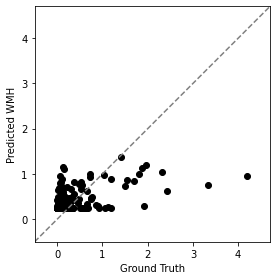

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.334	0.409	0.207		0.515		0.397
0.33	0.41	0.21		0.51		0.40



In [89]:
print("VNet-3")
normalization = 'groupnorm'
blocknum = 3
out_size = 2 ** blocknum
out_size = 192 // out_size
num_fc = [out_size * out_size * out_size,30,16,4]
net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                fc_features=[*num_fc])
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230430_ieie_vnet-{}'.format(blocknum)))
net.cuda()
mae, rmse, r2, pearson, spearman = predict(net, test_loader)
text = "------------------------------------------------------------------------------------------\n"
text += "MAE\tRMSE\tR-Squared\tPearson's r\tSpearman's r\t\n"
text += "==========================================================================================\n"
text += "{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}\t\t{:.3f}\n".format(mae, rmse, r2, pearson, spearman)
text += "{:.2f}\t{:.2f}\t{:.2f}\t\t{:.2f}\t\t{:.2f}\n".format(mae, rmse, r2, pearson, spearman)
print(text)

VNet-4


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


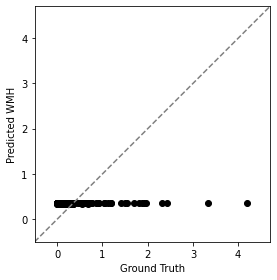

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.363	0.450	0.003		0.284		0.227
0.36	0.45	0.00		0.28		0.23



In [90]:
print("VNet-4")
blocknum = 4
out_size = 2 ** blocknum
out_size = 192 // out_size
num_fc = [out_size * out_size * out_size,30,16,4]
net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                fc_features=[*num_fc])
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230430_ieie_vnet-{}'.format(blocknum)))
net.cuda()
mae, rmse, r2, pearson, spearman = predict(net, test_loader)
text = "------------------------------------------------------------------------------------------\n"
text += "MAE\tRMSE\tR-Squared\tPearson's r\tSpearman's r\t\n"
text += "==========================================================================================\n"
text += "{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}\t\t{:.3f}\n".format(mae, rmse, r2, pearson, spearman)
text += "{:.2f}\t{:.2f}\t{:.2f}\t\t{:.2f}\t\t{:.2f}\n".format(mae, rmse, r2, pearson, spearman)
print(text)

SE-SFCN


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.57it/s]


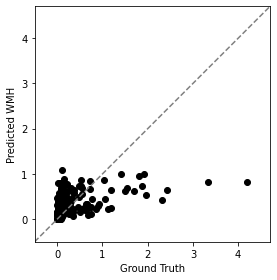

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.301	0.396	0.189		0.473		0.552
0.30	0.40	0.19		0.47		0.55



In [92]:
print("SE-SFCN")
def forward(self, x):
    x = self.feature_extractor(x)
    # add SEBlock
    x = self.seblock(x)*x
    x = self.classifier(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x

net = SFCN()
net.seblock = SEBlock(64)
net.fc = nn.Sequential(
    nn.Linear(384, 1),
    nn.LeakyReLU(),
)
net.forward = types.MethodType(forward, net)
net.load_state_dict(torch.load('pretrained/230430_ieie_se-sfcn'))
net.cuda()
mae, rmse, r2, pearson, spearman = predict(net, test_loader)
text = "------------------------------------------------------------------------------------------\n"
text += "MAE\tRMSE\tR-Squared\tPearson's r\tSpearman's r\t\n"
text += "==========================================================================================\n"
text += "{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}\t\t{:.3f}\n".format(mae, rmse, r2, pearson, spearman)
text += "{:.2f}\t{:.2f}\t{:.2f}\t\t{:.2f}\t\t{:.2f}\n".format(mae, rmse, r2, pearson, spearman)
print(text)

SFCN


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


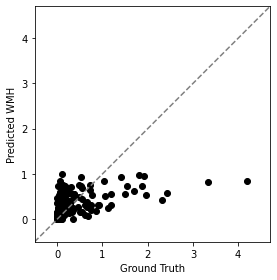

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.292	0.388	0.186		0.497		0.569
0.29	0.39	0.19		0.50		0.57



In [95]:
print("SFCN")
net = SFCN()
net.fc = nn.Sequential(
    nn.Linear(384, 1),
    nn.LeakyReLU(),
)
net.load_state_dict(torch.load('pretrained/230430_ieie_sfcn'))
net.cuda()
mae, rmse, r2, pearson, spearman = predict(net, test_loader)
text = "------------------------------------------------------------------------------------------\n"
text += "MAE\tRMSE\tR-Squared\tPearson's r\tSpearman's r\t\n"
text += "==========================================================================================\n"
text += "{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}\t\t{:.3f}\n".format(mae, rmse, r2, pearson, spearman)
text += "{:.2f}\t{:.2f}\t{:.2f}\t\t{:.2f}\t\t{:.2f}\n".format(mae, rmse, r2, pearson, spearman)
print(text)

Resnet10


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.58it/s]


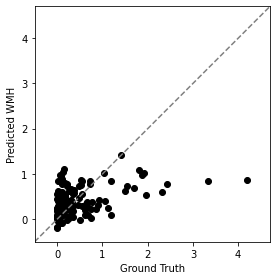

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.314	0.408	0.248		0.459		0.486
0.31	0.41	0.25		0.46		0.49



In [96]:
print("Resnet10")
net = resnet(model_depth=10, in_channels=1, num_classes=1)
net.load_state_dict(torch.load('pretrained/230430_ieie_resnet10'))
net.cuda()
mae, rmse, r2, pearson, spearman = predict(net, test_loader)
text = "------------------------------------------------------------------------------------------\n"
text += "MAE\tRMSE\tR-Squared\tPearson's r\tSpearman's r\t\n"
text += "==========================================================================================\n"
text += "{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}\t\t{:.3f}\n".format(mae, rmse, r2, pearson, spearman)
text += "{:.2f}\t{:.2f}\t{:.2f}\t\t{:.2f}\t\t{:.2f}\n".format(mae, rmse, r2, pearson, spearman)
print(text)

Resnet18


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.59it/s]


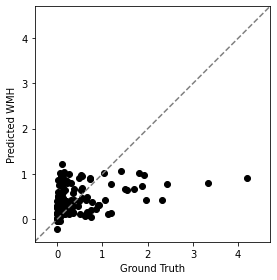

------------------------------------------------------------------------------------------
MAE	RMSE	R2	Pearson's r	Spearman's r	
0.334	0.428	0.223	0.396		0.431
0.33	0.43	0.22	0.40		0.43



In [98]:
print("Resnet18")
net = resnet(model_depth=18, in_channels=1, num_classes=1)
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230430_ieie_resnet18'))
net.cuda()
mae, rmse, r2, pearson, spearman = predict(net, test_loader)
text = "------------------------------------------------------------------------------------------\n"
text += "MAE\tRMSE\tR2\tPearson's r\tSpearman's r\t\n"
text += "==========================================================================================\n"
text += "{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}\n".format(mae, rmse, r2, pearson, spearman)
text += "{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t\t{:.2f}\n".format(mae, rmse, r2, pearson, spearman)
print(text)

Resnet26


100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


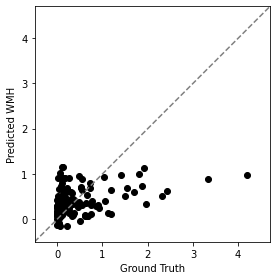

------------------------------------------------------------------------------------------
MAE	RMSE	R2	Pearson's r	Spearman's r	
0.330	0.426	0.210	0.409		0.438
0.33	0.43	0.21	0.41		0.44



In [99]:
print("Resnet26")
net = resnet26(in_channels=1, num_classes=1)
net.load_state_dict(torch.load('pretrained/230430_ieie_resnet26'))
net.cuda()
mae, rmse, r2, pearson, spearman = predict(net, test_loader)
text = "------------------------------------------------------------------------------------------\n"
text += "MAE\tRMSE\tR2\tPearson's r\tSpearman's r\t\n"
text += "==========================================================================================\n"
text += "{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}\n".format(mae, rmse, r2, pearson, spearman)
text += "{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t\t{:.2f}\n".format(mae, rmse, r2, pearson, spearman)
print(text)

Inception-Resnet-v2


100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


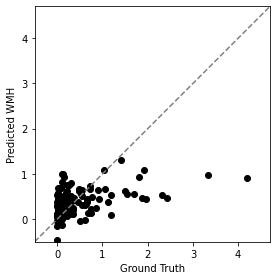

------------------------------------------------------------------------------------------
MAE	RMSE	R2	Pearson's r	Spearman's r	
0.297	0.391	0.218	0.482		0.518
0.30	0.39	0.22	0.48		0.52



In [100]:
print("Inception-Resnet-v2")
net = inception_resnet_v2(in_channels=1, num_classes=1)
net.load_state_dict(torch.load('pretrained/230430_ieie_inception-resnet-v2'))
net.cuda()
mae, rmse, r2, pearson, spearman = predict(net, test_loader)
text = "------------------------------------------------------------------------------------------\n"
text += "MAE\tRMSE\tR2\tPearson's r\tSpearman's r\t\n"
text += "==========================================================================================\n"
text += "{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}\n".format(mae, rmse, r2, pearson, spearman)
text += "{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t\t{:.2f}\n".format(mae, rmse, r2, pearson, spearman)
print(text)

---

In [35]:
from models.summary import summary_csv

# Inception-ResNet-v2
net = inception_resnet_v2(in_channels=1, num_classes=1)
net.cuda()
model_summary, size_info = summary_csv(net, (1, 192, 192, 192))  # summary(net, (1, 192, 192, 192), device='cpu')

layer_list = list(model_summary.index)
conv_cnt = 0
for layer in layer_list:
    if 'conv' in layer.lower():
        conv_cnt += 1
print('Total # of conv layers:', conv_cnt)

Total # of conv layers: 448


In [39]:
# ResNet26
net = resnet26(in_channels=1, num_classes=1)
net.cuda()
model_summary, size_info = summary_csv(net, (1, 192, 192, 192))  # summary(net, (1, 192, 192, 192), device='cpu')

layer_list = list(model_summary.index)
conv_cnt = 0
for layer in layer_list:
    if 'conv' in layer.lower():
        conv_cnt += 1
    elif 'BasicBlock' in layer:
        conv_cnt += 2  # BasicBlock은 conv layer가 2개 들어있음.
    elif 'Bottleneck' in layer:
        conv_cnt += 3  # BottleNeck은 conv layer가 3개 들어있음.
print('Total # of conv layers:', conv_cnt)

Total # of conv layers: 52


In [40]:
# ResNet18
net = resnet(model_depth=18, in_channels=1, num_classes=1)
model_summary, size_info = summary_csv(net, (1, 192, 192, 192))  # summary(net, (1, 192, 192, 192), device='cpu')

layer_list = list(model_summary.index)
conv_cnt = 0
for layer in layer_list:
    if 'conv' in layer.lower():
        conv_cnt += 1
    elif 'BasicBlock' in layer:
        conv_cnt += 2  # BasicBlock은 conv layer가 2개 들어있음.
    elif 'Bottleneck' in layer:
        conv_cnt += 3  # BottleNeck은 conv layer가 3개 들어있음.
print('Total # of conv layers:', conv_cnt)

Total # of conv layers: 36


In [43]:
# ResNet10
net = resnet(model_depth=10, in_channels=1, num_classes=1)
net.cuda()
model_summary, size_info = summary_csv(net, (1, 192, 192, 192))  # summary(net, (1, 192, 192, 192), device='cpu')

layer_list = list(model_summary.index)
conv_cnt = 0
for layer in layer_list:
    if 'conv' in layer.lower():
        conv_cnt += 1
    elif 'BasicBlock' in layer:
        conv_cnt += 2  # BasicBlock은 conv layer가 2개 들어있음.
    elif 'Bottleneck' in layer:
        conv_cnt += 3  # BottleNeck은 conv layer가 3개 들어있음.
print('Total # of conv layers:', conv_cnt)

Total # of conv layers: 20


In [57]:
# SFCN
net = SFCN()
net.fc = nn.Sequential(
    nn.Linear(384, 1),
    nn.LeakyReLU(),
)
net.cuda()
model_summary, size_info = summary_csv(net, (1, 192, 192, 192))  # summary(net, (1, 192, 192, 192), device='cpu')

layer_list = list(model_summary.index)
conv_cnt = 0
for layer in layer_list:
    if 'conv' in layer.lower():
        conv_cnt += 1
    elif 'BasicBlock' in layer:
        conv_cnt += 2  # BasicBlock은 conv layer가 2개 들어있음.
    elif 'Bottleneck' in layer:
        conv_cnt += 3  # BottleNeck은 conv layer가 3개 들어있음.
print('Total # of conv layers:', conv_cnt)

Total # of conv layers: 7


In [58]:
# V-Net-4
normalization = 'groupnorm'
blocknum = 4
out_size = 2 ** blocknum
out_size = 192 // out_size
num_fc = [out_size * out_size * out_size,30,16,4]
net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                fc_features=[*num_fc])
net.cuda()
model_summary, size_info = summary_csv(net, (1, 192, 192, 192))  # summary(net, (1, 192, 192, 192), device='cpu')

layer_list = list(model_summary.index)
conv_cnt = 0
for layer in layer_list:
    if 'conv' in layer.lower():
        conv_cnt += 1
print('Total # of conv layers:', conv_cnt)

Total # of conv layers: 22


In [59]:
# V-Net-3
normalization = 'groupnorm'
blocknum = 3
out_size = 2 ** blocknum
out_size = 192 // out_size
num_fc = [out_size * out_size * out_size,30,16,4]
net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                fc_features=[*num_fc])
net.cuda()
model_summary, size_info = summary_csv(net, (1, 192, 192, 192))  # summary(net, (1, 192, 192, 192), device='cpu')

layer_list = list(model_summary.index)
conv_cnt = 0
for layer in layer_list:
    if 'conv' in layer.lower():
        conv_cnt += 1
print('Total # of conv layers:', conv_cnt)

Total # of conv layers: 16


In [60]:
# V-Net-2
normalization = 'groupnorm'
blocknum = 2
out_size = 2 ** blocknum
out_size = 192 // out_size
num_fc = [out_size * out_size * out_size,30,16,4]
net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                fc_features=[*num_fc])
net.cuda()
model_summary, size_info = summary_csv(net, (1, 192, 192, 192))  # summary(net, (1, 192, 192, 192), device='cpu')

layer_list = list(model_summary.index)
conv_cnt = 0
for layer in layer_list:
    if 'conv' in layer.lower():
        conv_cnt += 1
print('Total # of conv layers:', conv_cnt)

Total # of conv layers: 10


In [20]:
# V-Net-1
normalization = 'groupnorm'
blocknum = 1
out_size = 2 ** blocknum
out_size = 192 // out_size
num_fc = [out_size * out_size * out_size,30,16,4]
net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                fc_features=[*num_fc])
net.cuda()
model_summary, size_info = summary_csv(net, (1, 192, 192, 192))  # summary(net, (1, 192, 192, 192), device='cpu')

layer_list = list(model_summary.index)
conv_cnt = 0
for layer in layer_list:
    if 'conv' in layer.lower():
        conv_cnt += 1
print('Total # of conv layers:', conv_cnt)

Total # of conv layers: 5


In [25]:
from models.segmentation.vnet_new import VNet_New
normalization = 'groupnorm'
blocknum = 4
net = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)
model_summary, size_info = summary_csv(net, (1, 192, 192, 192))  # summary(net, (1, 192, 192, 192), device='cpu')

layer_list = list(model_summary.index)
conv_cnt = 0
for layer in layer_list:
    if 'conv' in layer.lower():
        conv_cnt += 1
print('Total # of conv layers:', conv_cnt)

Total # of conv layers: 47


In [26]:
normalization = 'groupnorm'
blocknum = 3
net = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)
model_summary, size_info = summary_csv(net, (1, 192, 192, 192))  # summary(net, (1, 192, 192, 192), device='cpu')

layer_list = list(model_summary.index)
conv_cnt = 0
for layer in layer_list:
    if 'conv' in layer.lower():
        conv_cnt += 1
print('Total # of conv layers:', conv_cnt)

Total # of conv layers: 35


In [27]:
normalization = 'groupnorm'
blocknum = 2
net = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)
model_summary, size_info = summary_csv(net, (1, 192, 192, 192))  # summary(net, (1, 192, 192, 192), device='cpu')

layer_list = list(model_summary.index)
conv_cnt = 0
for layer in layer_list:
    if 'conv' in layer.lower():
        conv_cnt += 1
print('Total # of conv layers:', conv_cnt)

Total # of conv layers: 21


In [28]:
normalization = 'groupnorm'
blocknum = 1
net = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)
model_summary, size_info = summary_csv(net, (1, 192, 192, 192))  # summary(net, (1, 192, 192, 192), device='cpu')

layer_list = list(model_summary.index)
conv_cnt = 0
for layer in layer_list:
    if 'conv' in layer.lower():
        conv_cnt += 1
print('Total # of conv layers:', conv_cnt)

Total # of conv layers: 11


---

(array([ 3.,  3.,  4.,  8.,  7.,  9., 25., 17., 30., 25., 48., 51., 51.,
        52., 49., 53., 63., 66., 48., 57., 54., 49., 40., 45., 38., 29.,
        28., 15.,  4.,  4.]),
 array([-6.90775528, -6.62622307, -6.34469086, -6.06315865, -5.78162644,
        -5.50009423, -5.21856202, -4.93702982, -4.65549761, -4.3739654 ,
        -4.09243319, -3.81090098, -3.52936877, -3.24783656, -2.96630435,
        -2.68477214, -2.40323993, -2.12170772, -1.84017552, -1.55864331,
        -1.2771111 , -0.99557889, -0.71404668, -0.43251447, -0.15098226,
         0.13054995,  0.41208216,  0.69361437,  0.97514657,  1.25667878,
         1.53821099]),
 <BarContainer object of 30 artists>)

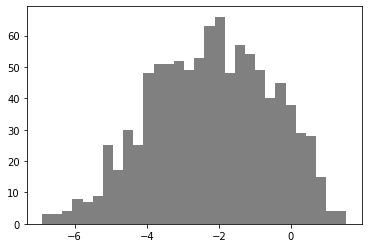

In [170]:
## 데이터셋 확인
aaa = []
for a in y:
    aaa.append(np.log(a + 1e-03))
plt.hist(aaa, bins=30, color='gray')

In [175]:
import inspect
from models.msle_loss import MSLELoss
print(inspect.getsource(MSLELoss))

class MSLELoss(nn.Module):
    def __init__(self, eps=1e-03):
        super(MSLELoss, self).__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        loss = self.mse(torch.log(yhat + self.eps), torch.log(y + self.eps))
        return loss



In [141]:
import types

def forward(self, inputs, targets=None, epoch=None):
    x = self.encoder(inputs)
    x = self.conv_out(x)
    encoding = x.view(x.size(0), -1)
    encoding_s = encoding

    if self.training and self.fds:
        if epoch >= self.start_smooth:
            encoding_s = self.FDS.smooth(encoding_s, targets, epoch)

    out = self.fc(encoding_s)
    if self.activation_fcn:
        out = F.relu(out)

    if self.training and self.fds:
        return out, encoding
    return torch.log(out)

out_size = 2 ** blocknum
out_size = 192 // out_size
num_fc = [out_size * out_size * out_size,30,16,4]
net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                fc_features=[*num_fc], dropout_p=dropout_rate, fds=fds)
net.conv_out = nn.Conv3d(net.n_filters, 1, 1, padding=0)

net.forward = types.MethodType(forward, net)

net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/seg_2304_vnetencoder-{}_{}_bestmodel'.format(blocknum, img_size)), strict=False)
net

DataParallel(
  (module): Regressor(
    (encoder): Sequential(
      (block_1): ResidualConvBlock(
        (conv): Sequential(
          (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): GroupNorm3D()
          (2): ReLU(inplace=True)
        )
      )
      (block_1_dw): DownsamplingConvBlock(
        (conv): Sequential(
          (0): Conv3d(16, 32, kernel_size=(2, 2, 2), stride=(2, 2, 2))
          (1): GroupNorm3D()
          (2): ReLU(inplace=True)
        )
      )
    )
    (decoder): Sequential(
      (block_2): ResidualConvBlock(
        (conv): Sequential(
          (0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): GroupNorm3D()
          (2): ReLU(inplace=True)
        )
      )
      (block_2_up): UpsamplingDeconvBlock(
        (conv): Sequential(
          (0): ConvTranspose3d(32, 16, kernel_size=(2, 2, 2), stride=(2, 2, 2))
          (1): GroupNorm3D()
          (2): ReLU(inplace=Tru

# EPOCH 1 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


# EPOCH 2 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.60it/s]


# EPOCH 3 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.59it/s]


# EPOCH 4 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.59it/s]


# EPOCH 5 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.54it/s]


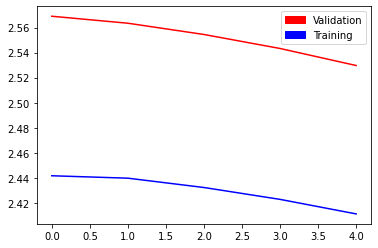

# EPOCH 6 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.58it/s]


# EPOCH 7 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.56it/s]


# EPOCH 8 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.57it/s]


# EPOCH 9 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.54it/s]


# EPOCH 10 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.59it/s]


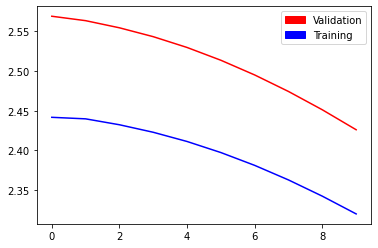

# EPOCH 11 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


# EPOCH 12 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


# EPOCH 13 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


# EPOCH 14 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.60it/s]


# EPOCH 15 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]


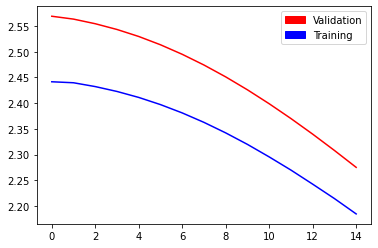

# EPOCH 16 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 17 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.56it/s]


# EPOCH 18 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.57it/s]


# EPOCH 19 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.58it/s]


# EPOCH 20 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]


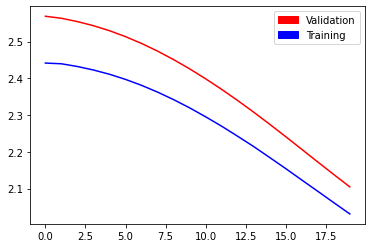

# EPOCH 21 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.60it/s]


# EPOCH 22 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


# EPOCH 23 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


# EPOCH 24 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]


# EPOCH 25 / 100


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


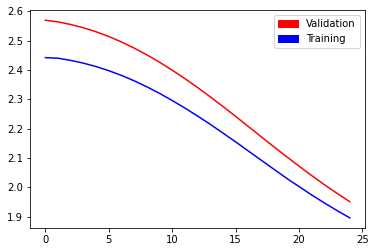

# EPOCH 26 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]


# EPOCH 27 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s]


# EPOCH 28 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 29 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


# EPOCH 30 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s]


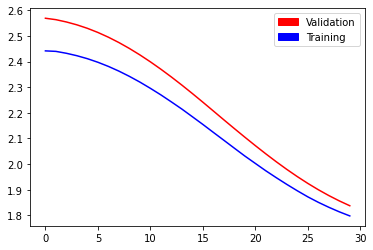

# EPOCH 31 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


# EPOCH 32 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s]


# EPOCH 33 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 34 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 35 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.59it/s]


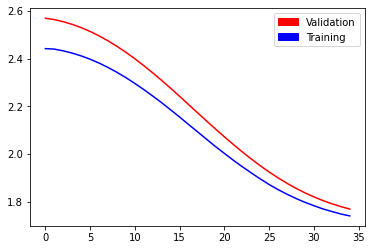

# EPOCH 36 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.57it/s]


# EPOCH 37 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.59it/s]


# EPOCH 38 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


# EPOCH 39 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s]


# EPOCH 40 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


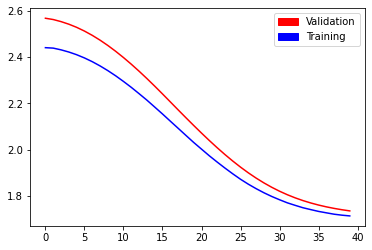

# EPOCH 41 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


# EPOCH 42 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 43 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


# EPOCH 44 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.59it/s]


# EPOCH 45 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.56it/s]


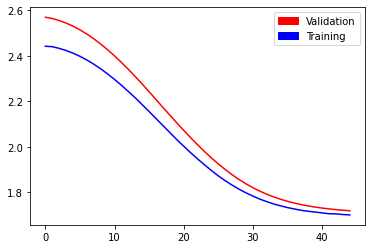

# EPOCH 46 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 47 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


# EPOCH 48 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 49 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.58it/s]


# EPOCH 50 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.56it/s]


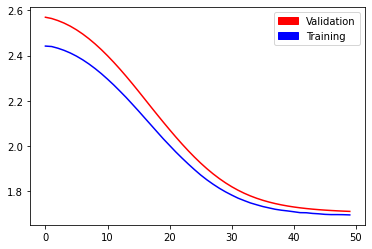

# EPOCH 51 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


# EPOCH 52 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s]


# EPOCH 53 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


# EPOCH 54 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 55 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


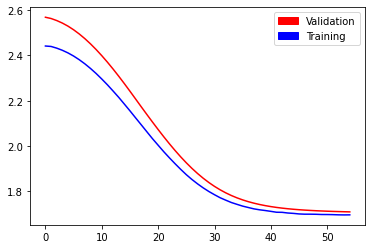

# EPOCH 56 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s]


# EPOCH 57 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.60it/s]


# EPOCH 58 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.58it/s]


# EPOCH 59 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s]


# EPOCH 60 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


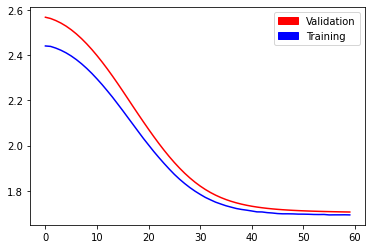

# EPOCH 61 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.54it/s]


# EPOCH 62 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.59it/s]


# EPOCH 63 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.57it/s]


# EPOCH 64 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.58it/s]


# EPOCH 65 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


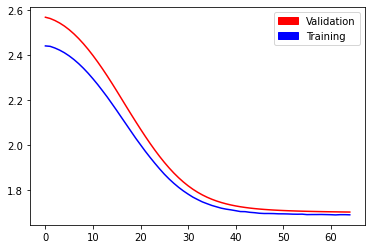

# EPOCH 66 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.57it/s]


# EPOCH 67 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


# EPOCH 68 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


# EPOCH 69 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


# EPOCH 70 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


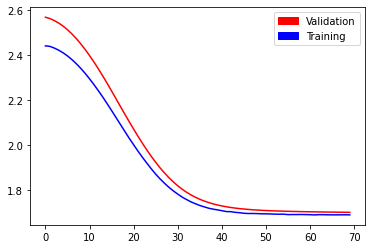

# EPOCH 71 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


# EPOCH 72 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.59it/s]


# EPOCH 73 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]


# EPOCH 74 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 75 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


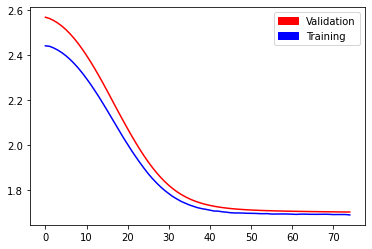

# EPOCH 76 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 77 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 78 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.58it/s]


# EPOCH 79 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


# EPOCH 80 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]


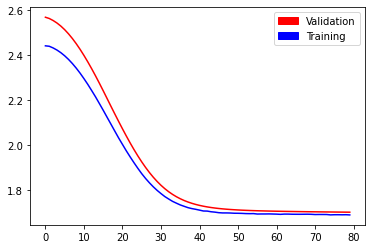

# EPOCH 81 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


# EPOCH 82 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


# EPOCH 83 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.60it/s]


# EPOCH 84 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.59it/s]


# EPOCH 85 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


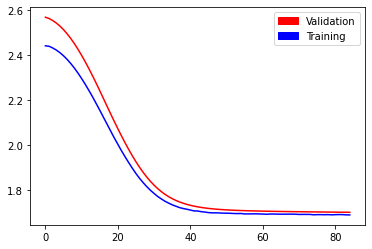

# EPOCH 86 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.54it/s]


# EPOCH 87 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.57it/s]


# EPOCH 88 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 89 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


# EPOCH 90 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.62it/s]


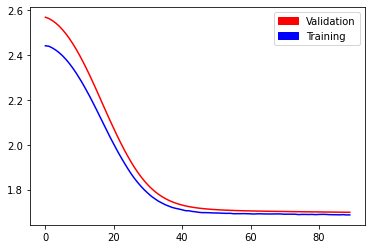

# EPOCH 91 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s]


# EPOCH 92 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s]


# EPOCH 93 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


# EPOCH 94 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.61it/s]


# EPOCH 95 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s]


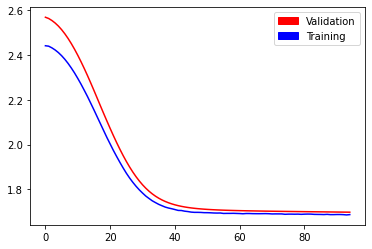

# EPOCH 96 / 100


100%|███████████████████████████████████████████| 49/49 [00:30<00:00,  1.59it/s]


# EPOCH 97 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.56it/s]


# EPOCH 98 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.57it/s]


# EPOCH 99 / 100


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]


# EPOCH 100 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.58it/s]


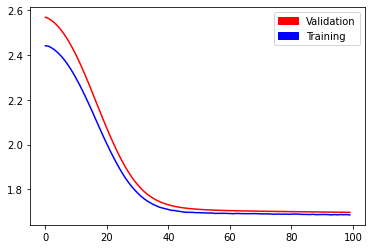

train_mae,██▇▇▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_msle,███▇▇▆▅▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_pearson,█▅▃▃▂▂▂▁▁▂▂▁▁▂▁▂▂▂▃▃▃▃▃▄▄▃▄▄▅▅▅▅▅▆▇▆▇▇▇▇
train_spearman,█▇▅▄▄▃▂▂▂▂▂▁▁▂▁▁▁▂▃▂▂▃▄▃▃▃▄▃▅▅▅▅▅▆▆▇▆█▆█
valid_mae,██▇▇▆▅▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_msle,███▇▇▆▅▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_pearson,▄▂▂▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇██
valid_spearman,▄▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇██
train_mae,0.31321
train_msle,1.68539
train_pearson,0.00656


In [176]:
from models.vnet_encoder_reg import Regressor
from models.msle_loss import MSLELoss

# V-Net-1 + MSLELoss
normalization = 'groupnorm'
blocknum = 1
dropout_rate = 0.
optim_class = optim.AdamW
lds = False
fds = False
start_update = 0

weight_filename = 'pretrained/230527_vnet-{}'.format(blocknum)
weight_filename += '+msleloss'

### VNet pretrained model 가져오기
set_seed()

out_size = 2 ** blocknum
out_size = 192 // out_size
num_fc = [out_size * out_size * out_size,30,16,4]
net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                fc_features=[*num_fc], dropout_p=dropout_rate, fds=fds)
net.conv_out = nn.Conv3d(net.n_filters, 1, 1, padding=0)
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/seg_2304_vnetencoder-{}_{}_bestmodel'.format(blocknum, img_size)), strict=False)
net.cuda()

# ### Parameter freeze
# for i, [name, param] in enumerate(net.named_parameters()):
#     if 'encoder' in name:
#         param.requires_grad = False

### W&B 설정
wandb.init(
    project='202305-WMHvolPredRunAll',
    config={"model": "VNet-{}".format(blocknum),
            "lr": lr, "epochs": num_epochs, "batch_size": batch_size,
            "cost_function": "msle_loss", "optimizer": optim_class.__name__, "weight_decay": weight_decay,
            "dropout": dropout_rate,
            "fds": fds, "lds": lds},
    notes='train with %d data'%(len(train_set)))
wandb.watch(net)

### 학습 시작
train_losses = []
validation_losses = []
min_valid_loss = 1.0

optimizer = optim_class(net.parameters(), lr=lr, weight_decay=weight_decay)
criterion1 = MSLELoss()
# criterion1 = nn.MSELoss()
criterion2 = nn.L1Loss()

set_seed()
for epoch in range(num_epochs):
    # train set
    augment = get_augmentation_transform()
    train_set.transform = tio.transforms.Compose([preprocess, augment])
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

    print('# EPOCH %d / %d'%(epoch+1, num_epochs))

    preds_t, truths_t, mse_t, mae_t = train(net, train_loader, optimizer, epoch=epoch, lds=lds, fds=fds)
    preds_v, truths_v, mse_v, mae_v = valid(net, test_loader)

    train_p, _ = pearsonr(preds_t, truths_t)
    train_s, _ = spearmanr(preds_t, truths_t)
    train_mae = mae_t / len(train_loader)
    train_mse = mse_t / len(train_loader)

    valid_p, _ = pearsonr(preds_v, truths_v)
    valid_s, _ = spearmanr(preds_v, truths_v)
    valid_mae = mae_v / len(test_loader)
    valid_mse = mse_v / len(test_loader)

    if min_valid_loss > valid_mse:
        min_valid_loss = valid_mse
        torch.save(net.state_dict(), weight_filename)

    train_losses.append(train_mse)
    validation_losses.append(valid_mse)
    if (epoch+1)%5 == 0:
        # loss curve
        plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
        red_patch = mpatches.Patch(color='red', label='Validation')
        blue_patch = mpatches.Patch(color='blue', label='Training')
        plt.legend(handles=[red_patch, blue_patch])
        plt.show()

    wandb.log({"train_mae": train_mae, "train_msle": train_mse, "valid_mae": valid_mae, "valid_msle": valid_mse,
               "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
wandb.finish()

100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.56it/s]


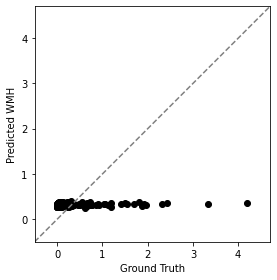

------------------------------------------------------------------------------------------
MAE	RMSE	R2	Pearson's r	Spearman's r	
0.349	0.440	0.003	0.149		0.178
0.35	0.44	0.00	0.15		0.18



In [178]:
weight_filename = 'pretrained/230527_vnet-{}'.format(blocknum)
weight_filename += '+msleloss'

out_size = 2 ** blocknum
out_size = 192 // out_size
num_fc = [out_size * out_size * out_size,30,16,4]
net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                fc_features=[*num_fc], dropout_p=dropout_rate, fds=fds)
net.conv_out = nn.Conv3d(net.n_filters, 1, 1, padding=0)
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load(weight_filename))
net.cuda()
mae, rmse, r2, pearson, spearman = predict(net, test_loader)
text = "------------------------------------------------------------------------------------------\n"
text += "MAE\tRMSE\tR2\tPearson's r\tSpearman's r\t\n"
text += "==========================================================================================\n"
text += "{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}\n".format(mae, rmse, r2, pearson, spearman)
text += "{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t\t{:.2f}\n".format(mae, rmse, r2, pearson, spearman)
print(text)

# EPOCH 1 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.54it/s]
/home/jhj/.conda/envs/a6000/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/jhj/.conda/envs/a6000/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


# EPOCH 2 / 100


100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


# EPOCH 3 / 100


100%|███████████████████████████████████████████| 49/49 [00:31<00:00,  1.54it/s]


# EPOCH 4 / 100


100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.52it/s]


# EPOCH 5 / 100


100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.52it/s]


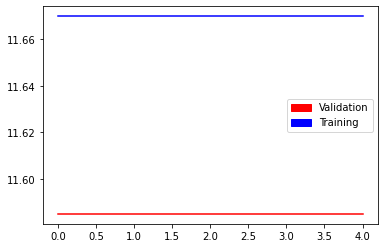

# EPOCH 6 / 100


100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


# EPOCH 7 / 100


100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s]


# EPOCH 8 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.45it/s]


# EPOCH 9 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.44it/s]


# EPOCH 10 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.42it/s]


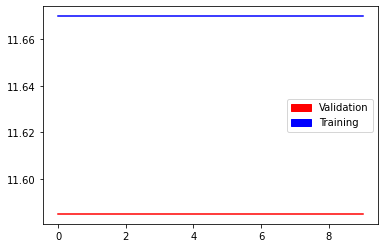

# EPOCH 11 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.48it/s]


# EPOCH 12 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.46it/s]


# EPOCH 13 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.45it/s]


# EPOCH 14 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.44it/s]


# EPOCH 15 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.44it/s]


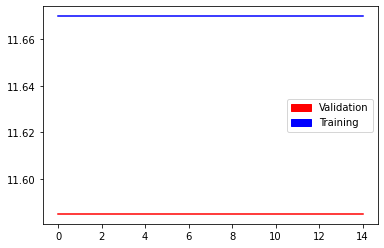

# EPOCH 16 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.46it/s]


# EPOCH 17 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.44it/s]


# EPOCH 18 / 100


100%|███████████████████████████████████████████| 49/49 [00:32<00:00,  1.50it/s]


# EPOCH 19 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.45it/s]


# EPOCH 20 / 100


100%|███████████████████████████████████████████| 49/49 [00:33<00:00,  1.46it/s]


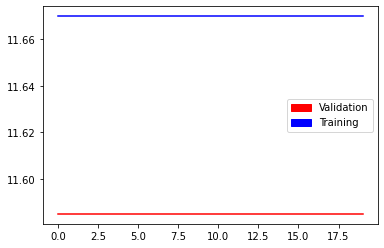

# EPOCH 21 / 100


100%|███████████████████████████████████████████| 49/49 [00:34<00:00,  1.43it/s]


# EPOCH 22 / 100


 90%|██████████████████████████████████████▌    | 44/49 [00:34<00:03,  1.29it/s]


KeyboardInterrupt: 

In [191]:
### MSLELoss with ReLU
from torch import autograd
from models.vnet_encoder_reg import Regressor
from models.msle_loss import MSLELoss

    
def train(model, train_loader, optimizer, epoch, lds=False, fds=False):
    total_loss_1, total_loss_2 = 0, 0
    preds, truths = np.array([]), np.array([])

    model.train()
    for inputs, labels, weights in tqdm(train_loader):
        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)
        weights = weights.to(device, dtype=torch.float)

        # feedforward
        if fds:
            outputs, _ = model(inputs, labels, epoch)
        else:
            outputs = model(inputs, labels, epoch)

        outputs = nn.()(outputs)
        pred = outputs.detach().cpu().numpy()
        truth = labels.detach().cpu().numpy()
        preds = np.append(preds, pred.reshape(pred.size), axis=0)
        truths = np.append(truths, truth.reshape(truth.size), axis=0)

        # calculate loss
        if lds:
            loss1 = weighted_mse_loss(outputs, labels, weights=weights)
            loss2 = criterion2(outputs, labels)
        else:
            loss1 = criterion1(outputs, labels)
            loss2 = criterion2(outputs, labels)

        # gradient initialization
        optimizer.zero_grad()
        # backpropagation
        loss1.backward()
        # weight update
        optimizer.step()

        total_loss_1 += loss1.data.item()
        total_loss_2 += loss2.data.item()

        gc.collect()
        torch.cuda.empty_cache()

    if fds and epoch >= start_update:
        encodings, targets = [], []
        with torch.no_grad():
            for inputs, labels, _ in tqdm(train_loader):
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.float)
                outputs, feature = model(inputs, labels, epoch)
                encodings.extend(feature.data.squeeze().cpu().numpy())
                targets.extend(labels.data.squeeze().cpu().numpy())

        encodings, targets = torch.from_numpy(np.vstack(encodings)).cuda(), torch.from_numpy(np.hstack(targets)).cuda()
        if device_count > 1:
            model.module.FDS.update_last_epoch_stats(epoch)
            model.module.FDS.update_running_stats(encodings, targets, epoch)
        else:
            model.FDS.update_last_epoch_stats(epoch)
            model.FDS.update_running_stats(encodings, targets, epoch)

    return preds, truths, total_loss_1, total_loss_2


def valid(model, valid_loader):
    total_loss_1, total_loss_2 = 0, 0
    preds, truths = np.array([]), np.array([])

    model.eval()
    with torch.no_grad():
        for inputs, labels, _ in tqdm(valid_loader):
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)

            outputs = model(inputs)

            outputs = nn.Softplus()(outputs)
            pred = outputs.detach().cpu().numpy()
            truth = labels.detach().cpu().numpy()
            preds = np.append(preds, pred.reshape(pred.size), axis=0)
            truths = np.append(truths, truth.reshape(truth.size), axis=0)

            loss1 = criterion1(outputs, labels)
            loss2 = criterion2(outputs, labels)

            total_loss_1 += loss1.data.item()
            total_loss_2 += loss2.data.item()

    return preds, truths, total_loss_1, total_loss_2

# V-Net-1 + MSLELoss
normalization = 'groupnorm'
blocknum = 1
dropout_rate = 0.
optim_class = optim.AdamW
lds = False
fds = False
start_update = 0

weight_filename = 'pretrained/230527_vnet-{}'.format(blocknum)
weight_filename += '+msleloss'

### VNet pretrained model 가져오기
set_seed()

out_size = 2 ** blocknum
out_size = 192 // out_size
num_fc = [out_size * out_size * out_size,30,16,4]
net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                fc_features=[*num_fc], dropout_p=dropout_rate, fds=fds)
net.conv_out = nn.Conv3d(net.n_filters, 1, 1, padding=0)
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/seg_2304_vnetencoder-{}_{}_bestmodel'.format(blocknum, img_size)), strict=False)
net.cuda()

# ### Parameter freeze
# for i, [name, param] in enumerate(net.named_parameters()):
#     if 'encoder' in name:
#         param.requires_grad = False

# ### W&B 설정
# wandb.init(
#     project='202305-WMHvolPredRunAll',
#     config={"model": "VNet-{}".format(blocknum),
#             "lr": lr, "epochs": num_epochs, "batch_size": batch_size,
#             "cost_function": "msle_loss", "optimizer": optim_class.__name__, "weight_decay": weight_decay,
#             "dropout": dropout_rate,
#             "fds": fds, "lds": lds},
#     notes='MSLE loss without softplus')
# wandb.watch(net)

### 학습 시작
train_losses = []
validation_losses = []
min_valid_loss = 1.0

optimizer = optim_class(net.parameters(), lr=lr, weight_decay=weight_decay)
criterion1 = MSLELoss()
# criterion1 = nn.MSELoss()
criterion2 = nn.L1Loss()

set_seed()
for epoch in range(num_epochs):
    # train set
    augment = get_augmentation_transform()
    train_set.transform = tio.transforms.Compose([preprocess, augment])
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

    print('# EPOCH %d / %d'%(epoch+1, num_epochs))

    preds_t, truths_t, mse_t, mae_t = train(net, train_loader, optimizer, epoch=epoch, lds=lds, fds=fds)
    preds_v, truths_v, mse_v, mae_v = valid(net, test_loader)

    train_p, _ = pearsonr(preds_t, truths_t)
    train_s, _ = spearmanr(preds_t, truths_t)
    train_mae = mae_t / len(train_loader)
    train_mse = mse_t / len(train_loader)

    valid_p, _ = pearsonr(preds_v, truths_v)
    valid_s, _ = spearmanr(preds_v, truths_v)
    valid_mae = mae_v / len(test_loader)
    valid_mse = mse_v / len(test_loader)

    if min_valid_loss > valid_mse:
        min_valid_loss = valid_mse
        torch.save(net.state_dict(), weight_filename)

    train_losses.append(train_mse)
    validation_losses.append(valid_mse)
    if (epoch+1)%5 == 0:
        # loss curve
        plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
        red_patch = mpatches.Patch(color='red', label='Validation')
        blue_patch = mpatches.Patch(color='blue', label='Training')
        plt.legend(handles=[red_patch, blue_patch])
        plt.show()

#     wandb.log({"train_mae": train_mae, "train_msle": train_mse, "valid_mae": valid_mae, "valid_msle": valid_mse,
#                "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
# wandb.finish()

In [179]:
wandb.finish()